In [3]:
import os
# import h5py
from src.util.misc import saveraster
from src.j_output.user_output import TmrtOutput
# from j_dataprep import DEMs

# from j_dataprep.landcover import LandCover
from osgeo import gdal
# from j_dataprep.DEMs import Buildings
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import rasterize

# for average heat day no trees

In [4]:
bbox_dict = {
        'historisch': [(175905, 317210, 176505, 317810), (84050, 447180, 84650, 447780), (80780, 454550, 81380, 455150),
                       (233400, 581500, 234000, 582100), (136600, 455850, 137200, 456450),
                       (121500, 487000, 122100, 487600)
                       ],
        'tuindorp': [(76800, 455000, 78200, 455700), (152600, 463250, 153900, 463800), (139140, 469570, 139860, 470400),
                     (190850, 441790, 191750, 442540), (113100, 551600, 113650, 552000), (32050, 391900, 32850, 392500)

                     ],
        'vinex': [(146100, 486500, 147000, 487400), (153750, 467550, 154650, 468450), (115300, 517400, 116100, 518250),
                  (102000, 475900, 103100, 476800), (160750, 388450, 161650, 389350), (84350, 449800, 85250, 450700)

                  ],
        'volkswijk': [(104200, 490550, 105100, 491450), (78200, 453900, 79100, 454800), (83500, 447020, 84050, 447900),
                      (136200, 456500, 137100, 457300), (182700, 579200, 183800, 579750),
                      (233400, 582800, 234300, 583700)

                      ],
        'bloemkool': [(81700, 427490, 82700, 428200), (84050, 444000, 84950, 444900), (116650, 518700, 117550, 519600),
                      (235050, 584950, 235950, 585850), (210500, 473900, 211400, 474800),
                      (154700, 381450, 155700, 382150)

                      ],

        'stedelijk': [
            (90300, 436900, 91300, 437600), (91200, 438500, 92100, 439300), (121350, 483750, 122250, 484650),
            (118400, 486400, 119340, 487100)
        ]
}

gpkg_names = ['typos', "tuindorp", 'vinexwijk', 'volkswijk', 'bloemkoolwijk', 'stedelijk_bouwblok']

base_folder = "E:/Geomatics/thesis/_analysisfinalfurther/"
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
locs = [0, 1, 2, 3, 4, 5]



In [ ]:

for typ in typologies:
    typology_path = os.path.join(base_folder, typ)
    for i in locs:
        try:
            boundingbox = bbox_dict[typ][i]
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        dtm_path = typology_path + f"/loc_{i}/final_dtm.tif"

        buildingslocation = Buildings(boundingbox)


        landcover = LandCover(boundingbox, dataset_path=dtm_path, building_data=buildingslocation.building_geometries)

        building_mask = ~landcover.building_mask
        water_mask = landcover.water_mask

        if water_mask is not None:
            total_mask = np.logical_or(building_mask, ~water_mask).astype(np.uint8)
        else:
            total_mask = building_mask.astype(np.uint8)

        dataset = gdal.Open(dtm_path)
        saveraster(dataset, typology_path + f'/loc_{i}/masks.tif', total_mask)

In [16]:
gpkg_path = "D:/Geomatics/thesis/_typos/typos.gpkg"

j = 0

for typ in typologies:
    typology_path = os.path.join(base_folder, typ)

    layer_name = gpkg_names[j]
    gdf = gpd.read_file(gpkg_path, layer=layer_name)

    for i in locs:
        try:
            boundingbox = bbox_dict[typ][i]
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        dtm_path = typology_path + f"/loc_{i}/final_dtm.tif"
        with rasterio.open(dtm_path) as src:
            dtm_meta = src.meta.copy()
            transform = src.transform
            crs = src.crs
            shape = (src.height, src.width)

        dataset = gdal.Open(dtm_path)
        file = dataset.GetRasterBand(1).ReadAsArray()

        body = np.zeros_like(file)

        geom_mask = rasterize(
            [(geom, 1) for geom in gdf.geometry],
            out_shape=shape,
            transform=transform,
            fill=0,
            dtype='uint8'
        )
        new_mask = (geom_mask == 0).astype(np.uint8)

        existing_mask_gdal = gdal.Open(f'{typology_path}/loc_{i}/masks.tif')
        existing_mask = existing_mask_gdal.ReadAsArray()

        total_mask = np.logical_or(existing_mask, new_mask).astype(np.uint8)

        saveraster(dataset, typology_path + f'/loc_{i}/masks_combined.tif', total_mask)

    j += 1

Skipping stedelijk, index 4 – bounding box not found.
Skipping stedelijk, index 5 – bounding box not found.


In [5]:
import os
from osgeo import gdal

base_folder = "D:/Geomatics/thesis/_analysisfinalfurther"
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
locs = [0, 1, 2, 3, 4, 5]
sol = 'solweig_green_ext'


for typ in typologies:
    typology_path = os.path.join(base_folder, typ)

    for i in locs:
        try:
            _ = bbox_dict[typ][i]  # Still check if bbox exists, even if we don't store it
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        area_path = os.path.join(typology_path, f"loc_{i}", sol)
        mask_path = os.path.join(typology_path, f'loc_{i}', 'masks_combined.tif')

        if not os.path.exists(mask_path):
            print(f"Skipping {typ}, index {i} – mask not found.")
            continue

        mask_gdal = gdal.Open(mask_path)
        mask = ~mask_gdal.ReadAsArray().astype(bool)

        tmrt_processor = TmrtOutput(output_folder=area_path, building_mask=mask)

        # Specific 12:00 time
        try:
            tmrt_12 = tmrt_processor.tmrt_arrays_by_time["1200"]

        except KeyError:
            print(f"No 12:00 TMRT array for {typ} loc {i}")
        saveraster(mask_gdal, f"D:/Geomatics/thesis/_analysisfinalfurther/check/{typ}_{i}.tif", tmrt_12)

# Create DataFrame and save


KeyboardInterrupt: 

In [9]:
import os
import pandas as pd
from osgeo import gdal

base_folder = "D:/Geomatics/thesis/_analysisfinalfurther"
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
locs = [0, 1, 2, 3, 4, 5]
sol = 'solweig_green_avg'

all_rows = []

for typ in typologies:
    typology_path = os.path.join(base_folder, typ)

    for i in locs:
        try:
            _ = bbox_dict[typ][i]  # Still check if bbox exists, even if we don't store it
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        area_path = os.path.join(typology_path, f"loc_{i}", sol)
        mask_path = os.path.join(typology_path, f'loc_{i}', 'masks_combined.tif')

        if not os.path.exists(mask_path):
            print(f"Skipping {typ}, index {i} – mask not found.")
            continue

        mask_gdal = gdal.Open(mask_path)
        mask = ~mask_gdal.ReadAsArray().astype(bool)

        tmrt_processor = TmrtOutput(output_folder=area_path, building_mask=mask)

        # Grouped time stats
        for time_group, avg_array in tmrt_processor.averaged_tmrt.items():
            if avg_array is None:
                continue

            stats = tmrt_processor.calculate_stats_and_bins(avg_array, isTmrt=True)

            row = {
                'typology': typ,
                'location': i,
                'time': time_group,
                'mean': stats['mean'],
                'median': stats['median'],
                'min': stats['min'],
                'max': stats['max'],
            }

            for idx, bin_info in enumerate(stats['bins']):
                bin_range = f"{bin_info['range'][0]}_{bin_info['range'][1]}"
                row[f"area_m2_bin_{idx}_{bin_range}"] = bin_info['area_m2']
                row[f"percent_bin_{idx}_{bin_range}"] = bin_info['percentage']

            all_rows.append(row)

        # Specific 12:00 time
        try:
            tmrt_12 = tmrt_processor.tmrt_arrays_by_time["1200"]
            if tmrt_12 is not None:
                stats_12 = tmrt_processor.calculate_stats_and_bins(tmrt_12, isTmrt=True)

                row_12 = {
                    'typology': typ,
                    'location': i,
                    'time': "12:00",
                    'mean': stats_12['mean'],
                    'median': stats_12['median'],
                    'min': stats_12['min'],
                    'max': stats_12['max'],
                }

                for idx, bin_info in enumerate(stats_12['bins']):
                    bin_range = f"{bin_info['range'][0]}_{bin_info['range'][1]}"
                    row_12[f"area_m2_bin_{idx}_{bin_range}"] = bin_info['area_m2']
                    row_12[f"percent_bin_{idx}_{bin_range}"] = bin_info['percentage']

                all_rows.append(row_12)
        except KeyError:
            print(f"No 12:00 TMRT array for {typ} loc {i}")

# Create DataFrame and save
df = pd.DataFrame(all_rows)
output_csv_path = "outputstats/avg_tree.csv"
df.to_csv(output_csv_path, index=False)

print(f"Saved TMRT stats to: {output_csv_path}")


Skipping stedelijk, index 4 – bounding box not found.
Skipping stedelijk, index 5 – bounding box not found.
Saved TMRT stats to: outputstats/avg_tree.csv


In [10]:
df_avg_tree = pd.read_csv("outputstats/avg_tree.csv")
df_avg_notree = pd.read_csv("outputstats/avg_notree.csv")
df_ext_tree = pd.read_csv("outputstats/ext_tree.csv")
df_ext_notree = pd.read_csv("outputstats/ext_notree.csv")

for df, label in zip(
    [df_avg_tree, df_avg_notree, df_ext_tree, df_ext_notree],
    ['avg_tree', 'avg_notree', 'ext_tree', 'ext_notree']
):
    df["source"] = label

In [11]:
df_all = pd.concat([df_avg_tree, df_avg_notree, df_ext_tree, df_ext_notree], ignore_index=True)
df_all['without_trees'] = df_all['source'].str.contains('notree')
df_all['avg_or_ext'] = df_all['source'].str.extract(r'^(avg|ext)')

In [12]:
print(df_all)

       typology  location       time       mean     median        min  \
0    historisch         0    morning  30.907648  29.943651  21.557777   
1    historisch         0  afternoon  45.844547  44.003124  27.983261   
2    historisch         0    evening  31.274393  29.144379  26.333500   
3    historisch         0      12:00  47.497047  55.005140  27.699450   
4    historisch         1    morning  30.750984  29.244358  21.473877   
..          ...       ...        ...        ...        ...        ...   
539   stedelijk         2      12:00  62.769985  66.825370  33.777508   
540   stedelijk         3    morning  42.252464  43.743793  26.888145   
541   stedelijk         3  afternoon  61.926613  63.177876  35.296463   
542   stedelijk         3    evening  41.390260  38.298210  33.912075   
543   stedelijk         3      12:00  63.899185  66.905500  33.774803   

           max  area_m2_bin_0_-inf_15.0  percent_bin_0_-inf_15.0  \
0    42.408382                      0.0                

In [13]:
df_all = df_all[df_all['time'] != '12:00']

Saved plot as plots/mean_comparison_plot_morning_avg.png
Saved plot as plots/median_comparison_plot_morning_avg.png
Saved plot as plots/min_comparison_plot_morning_avg.png
Saved plot as plots/max_comparison_plot_morning_avg.png
Saved plot as plots/mean_comparison_plot_afternoon_avg.png
Saved plot as plots/median_comparison_plot_afternoon_avg.png
Saved plot as plots/min_comparison_plot_afternoon_avg.png
Saved plot as plots/max_comparison_plot_afternoon_avg.png
Saved plot as plots/mean_comparison_plot_evening_avg.png
Saved plot as plots/median_comparison_plot_evening_avg.png
Saved plot as plots/min_comparison_plot_evening_avg.png
Saved plot as plots/max_comparison_plot_evening_avg.png


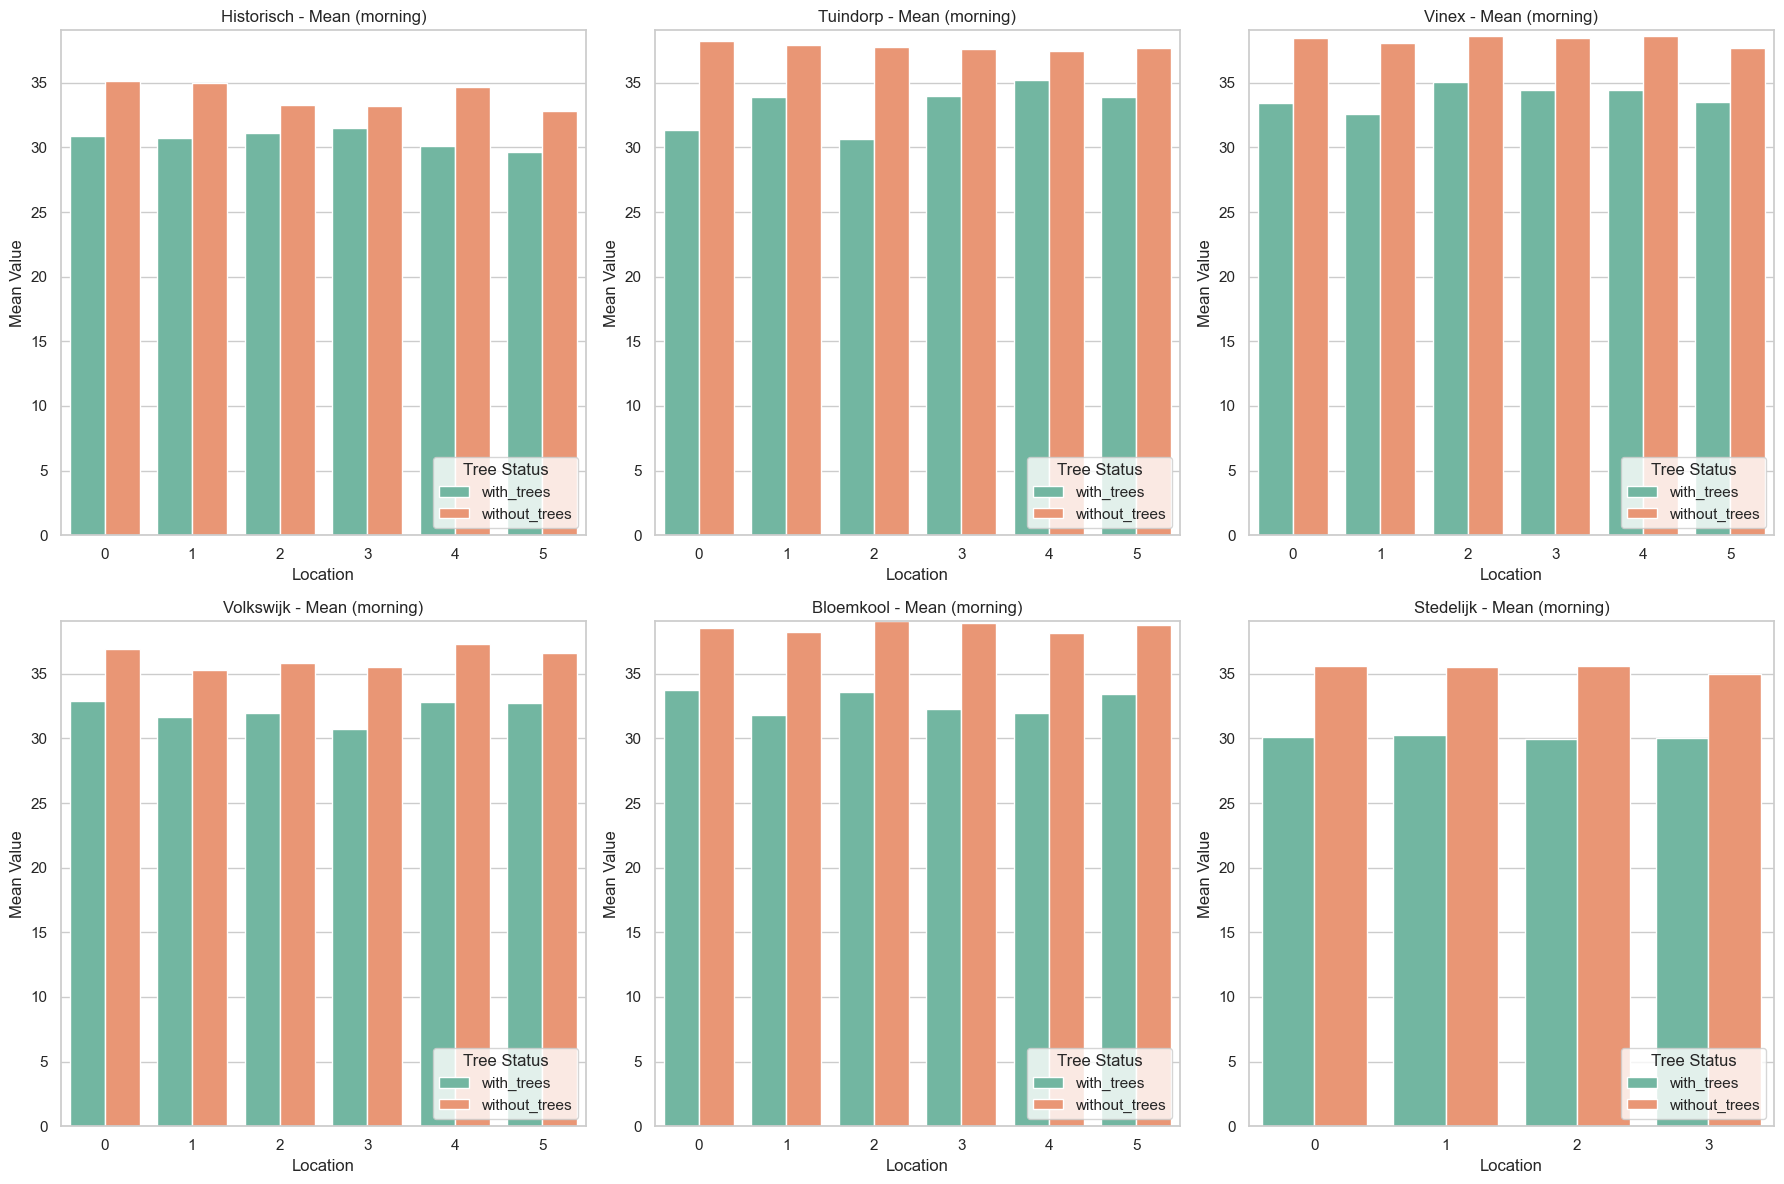

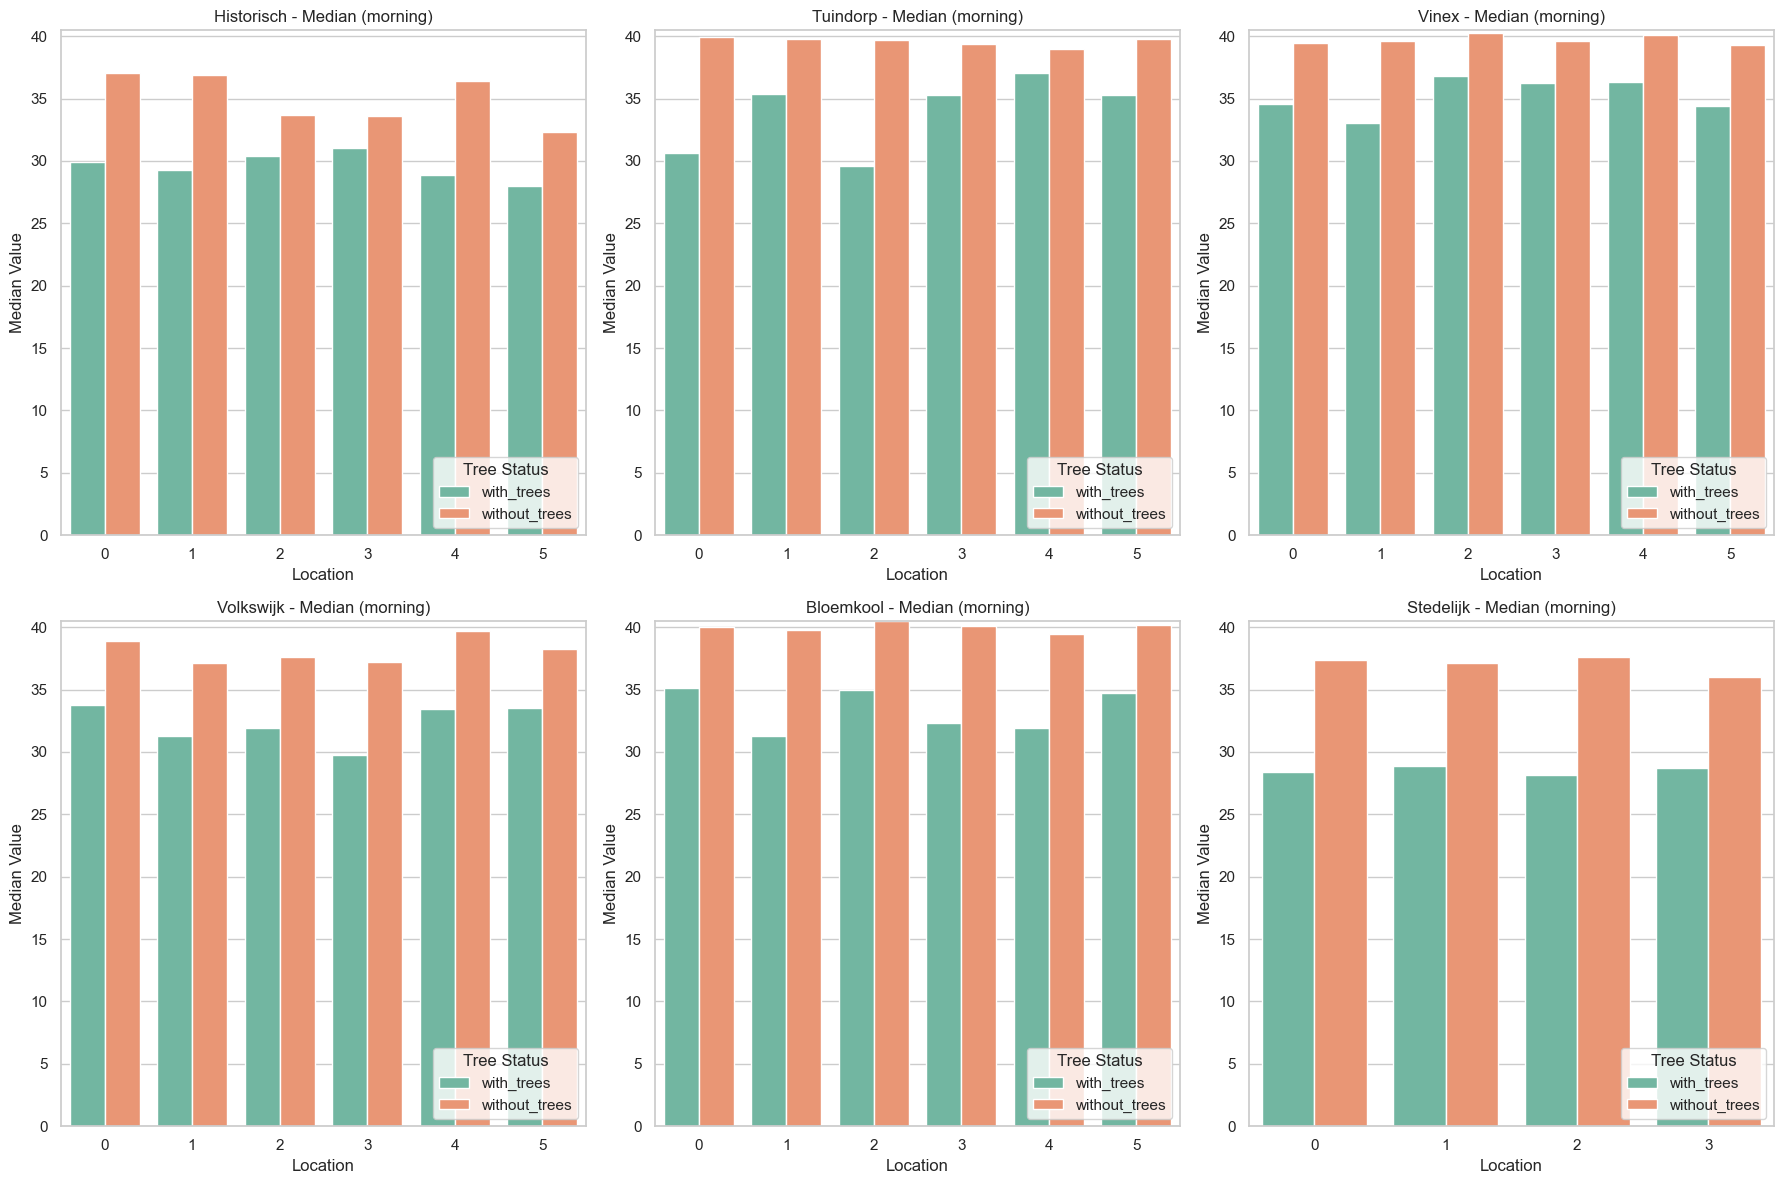

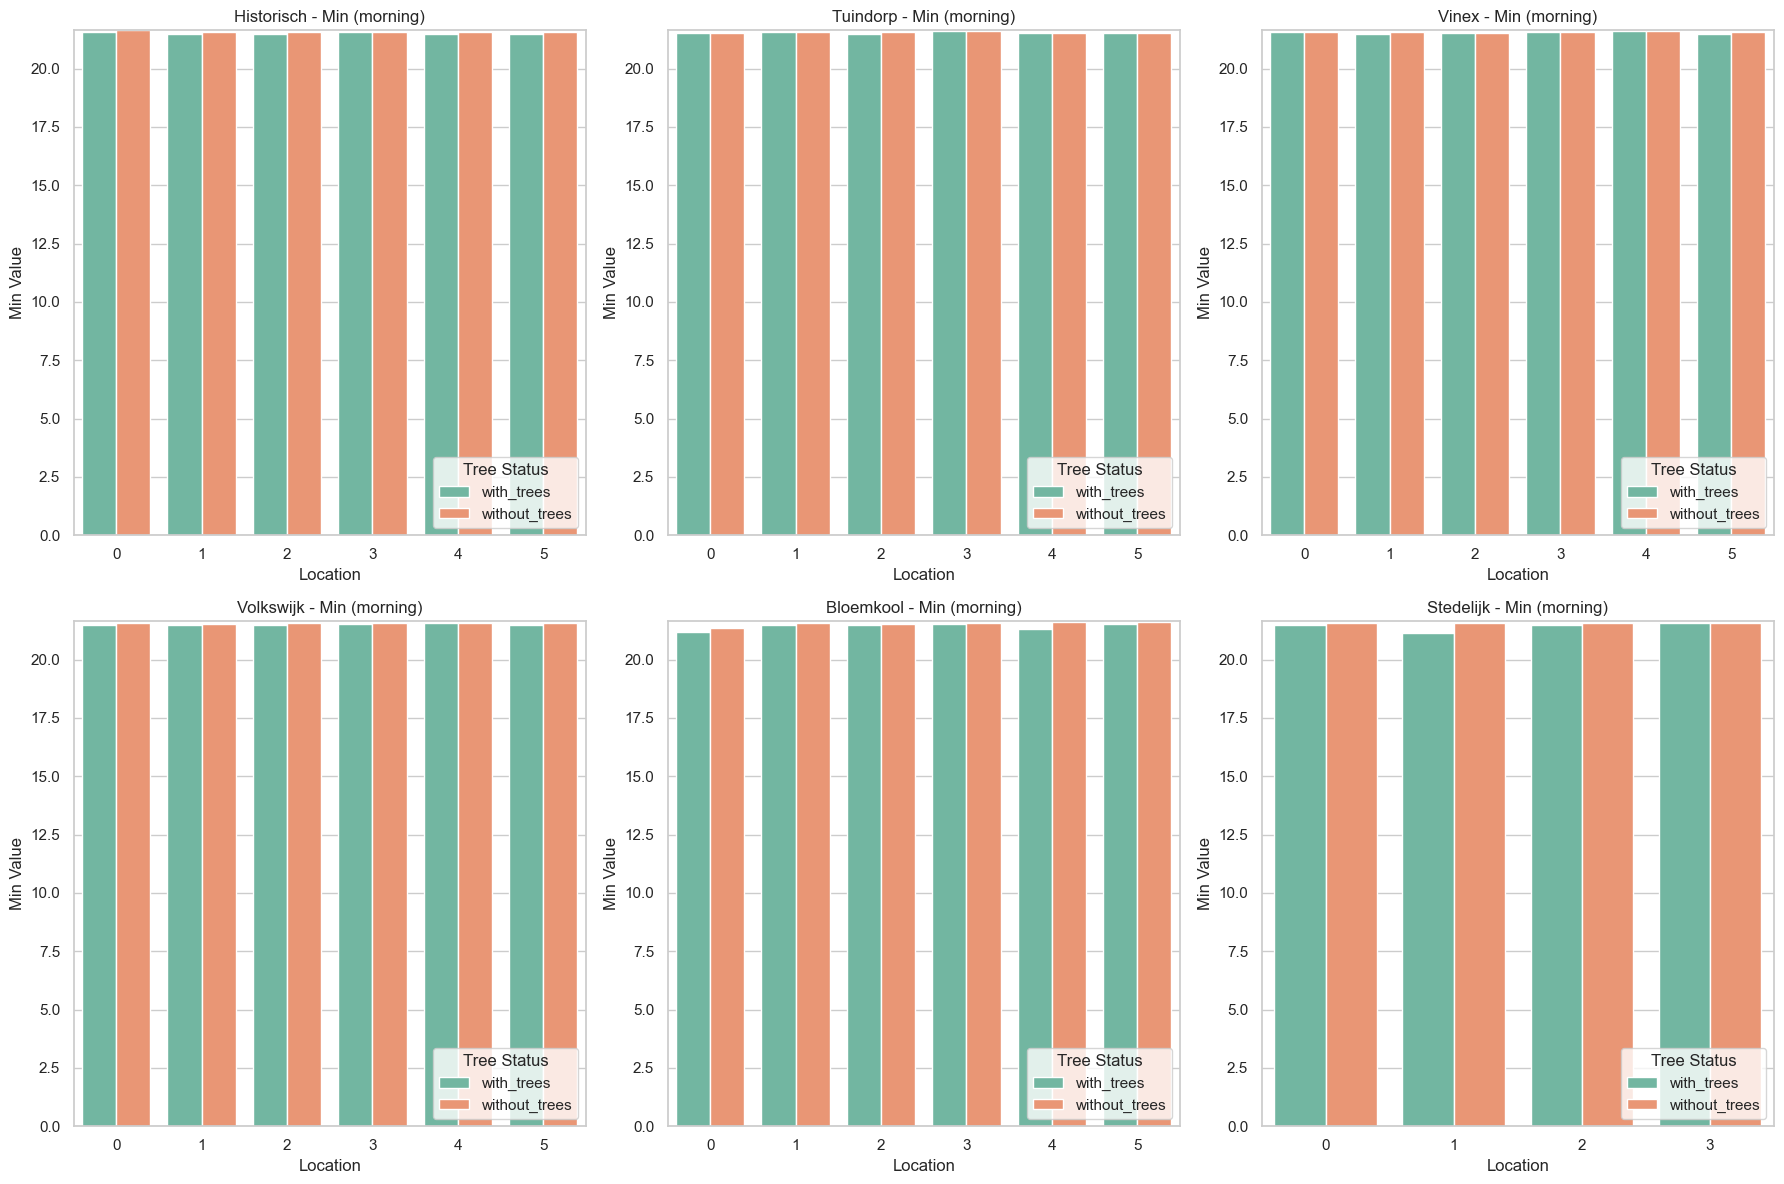

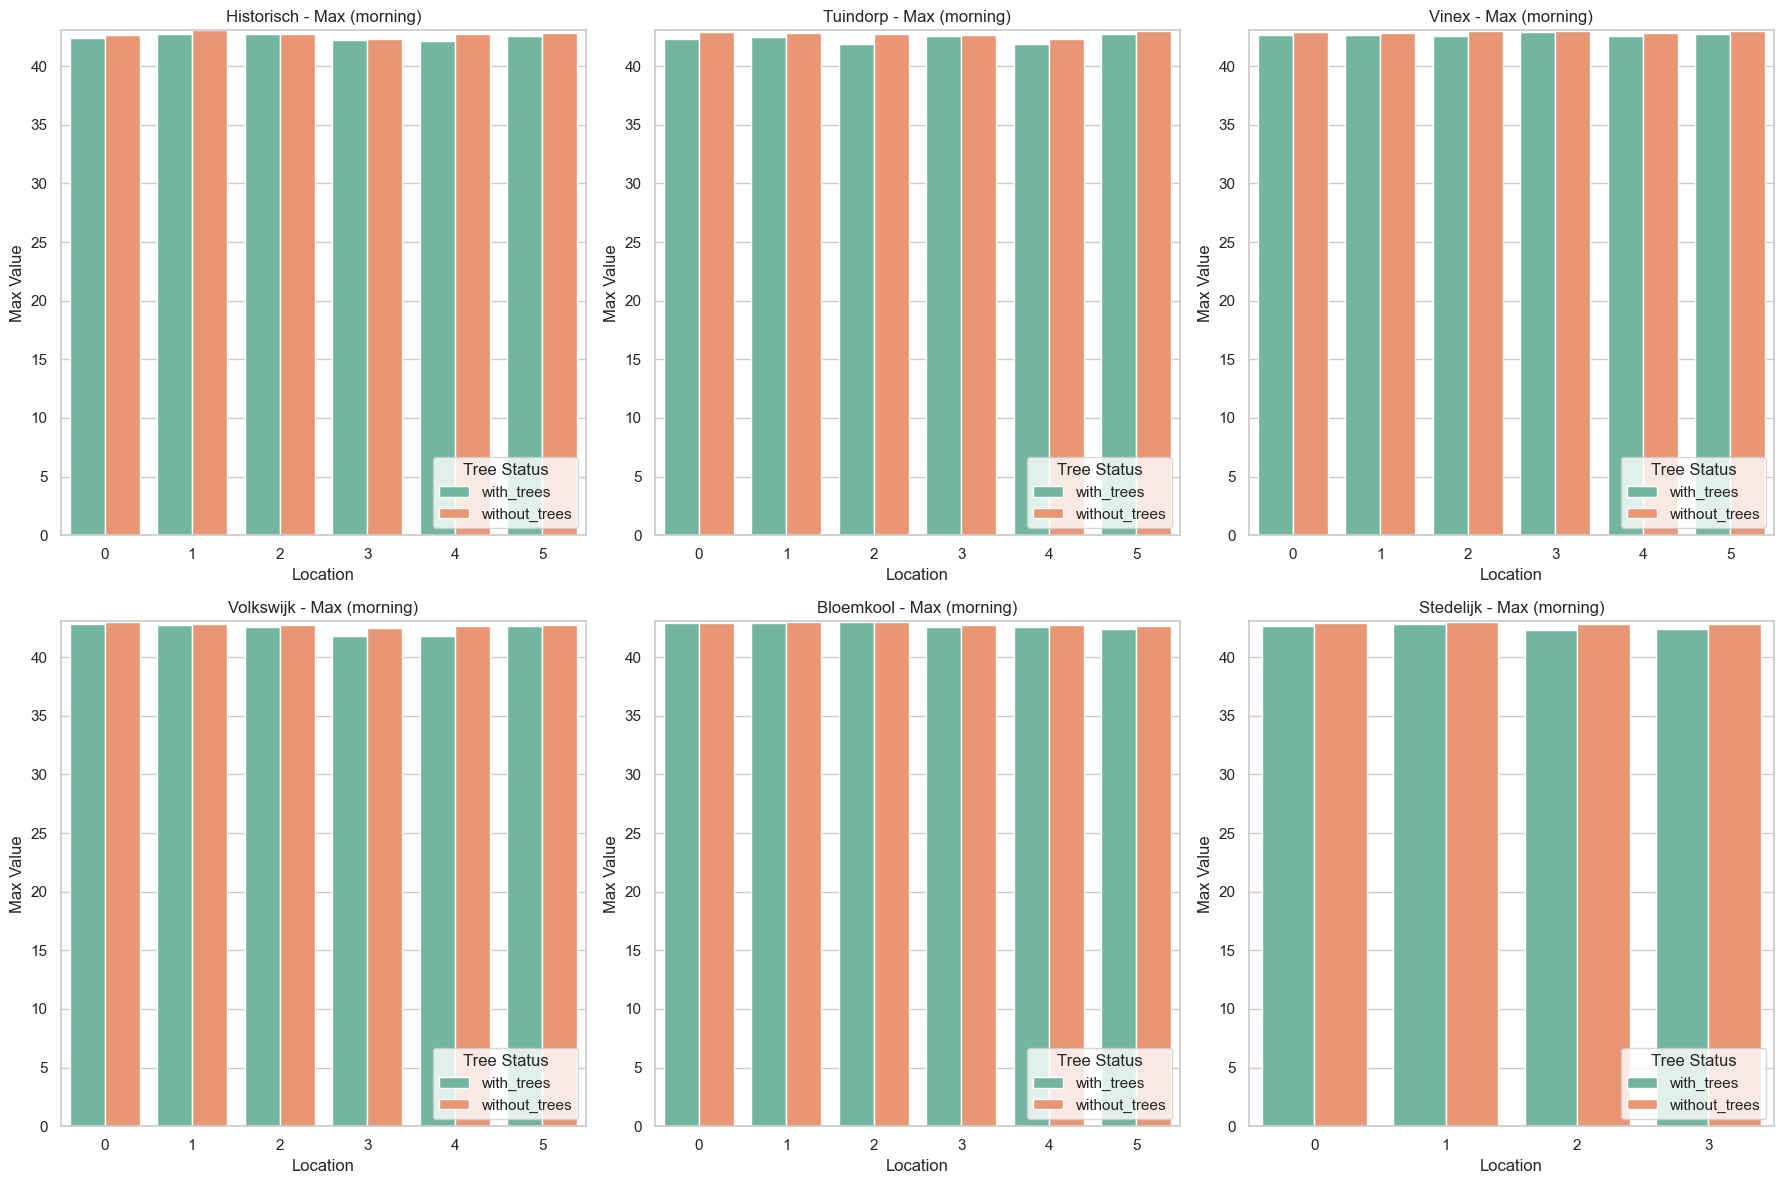

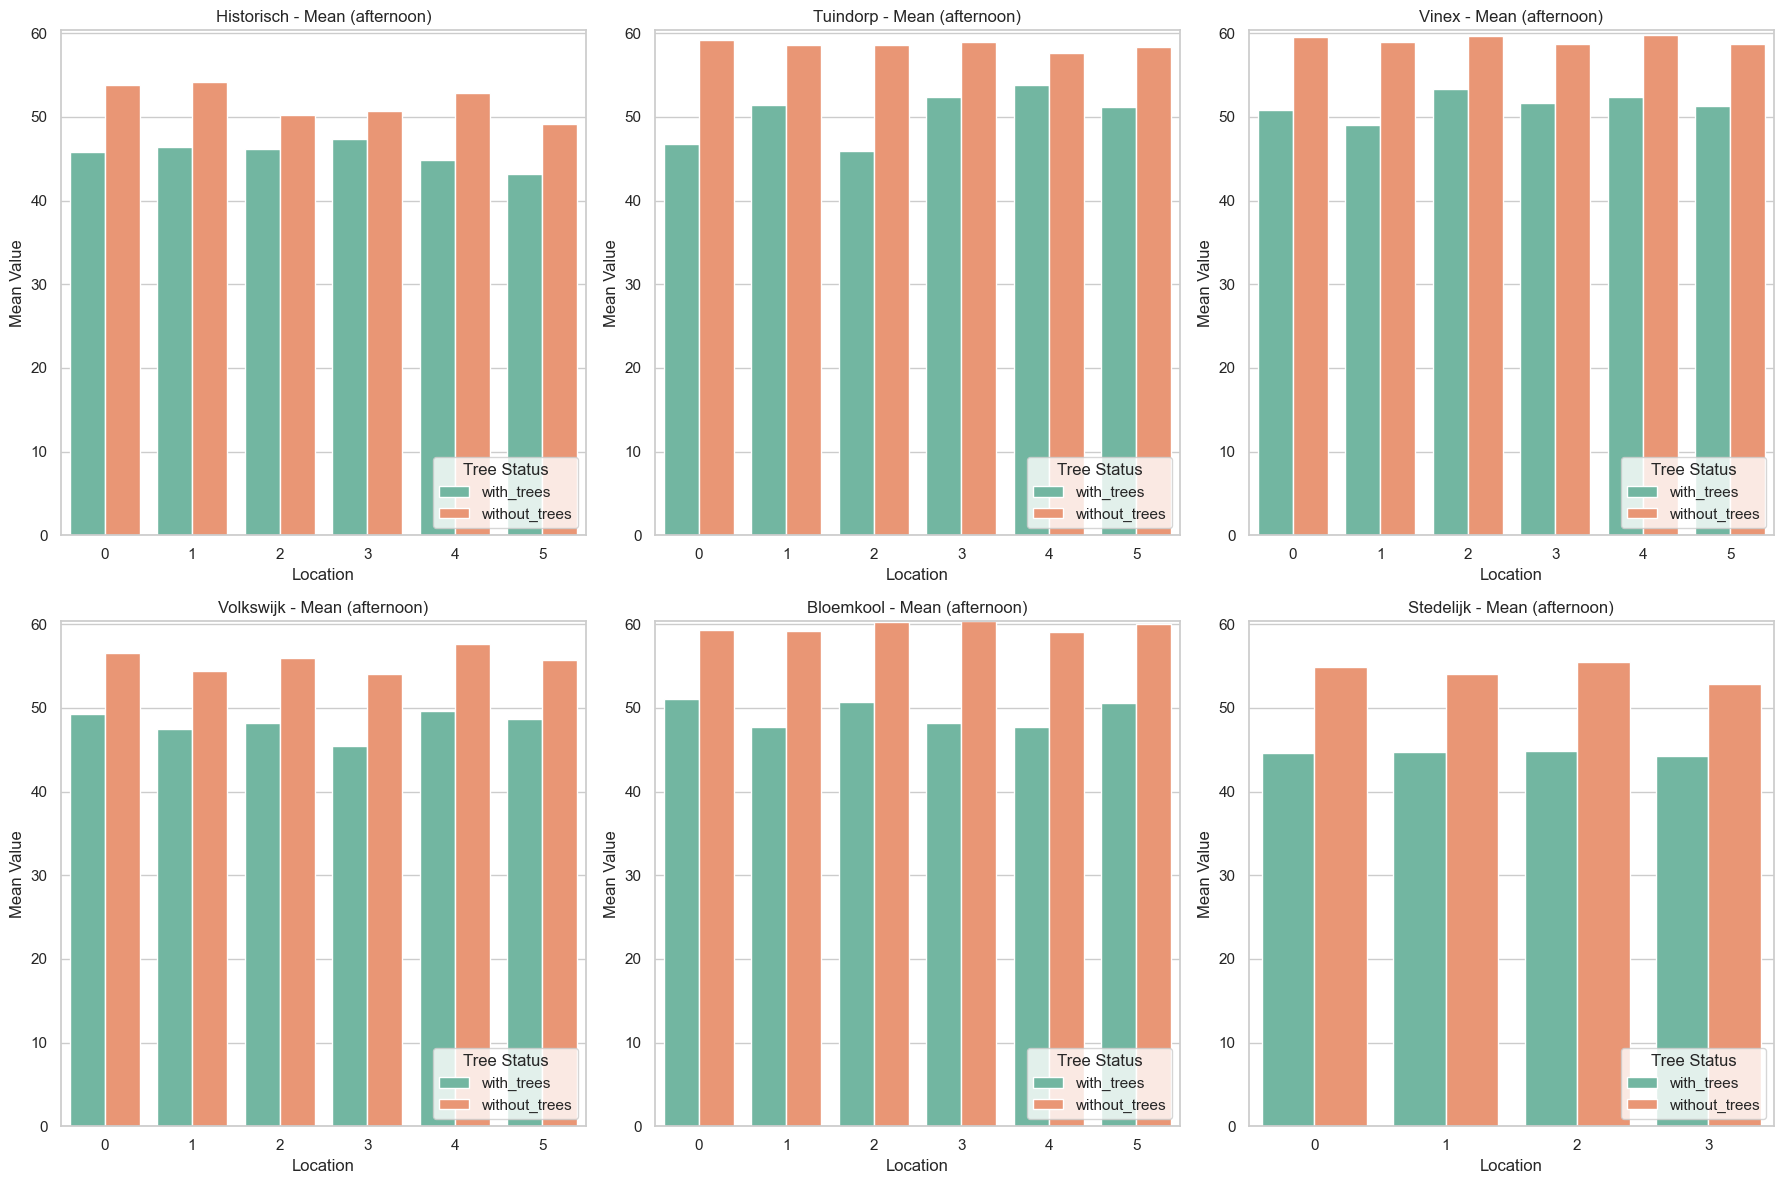

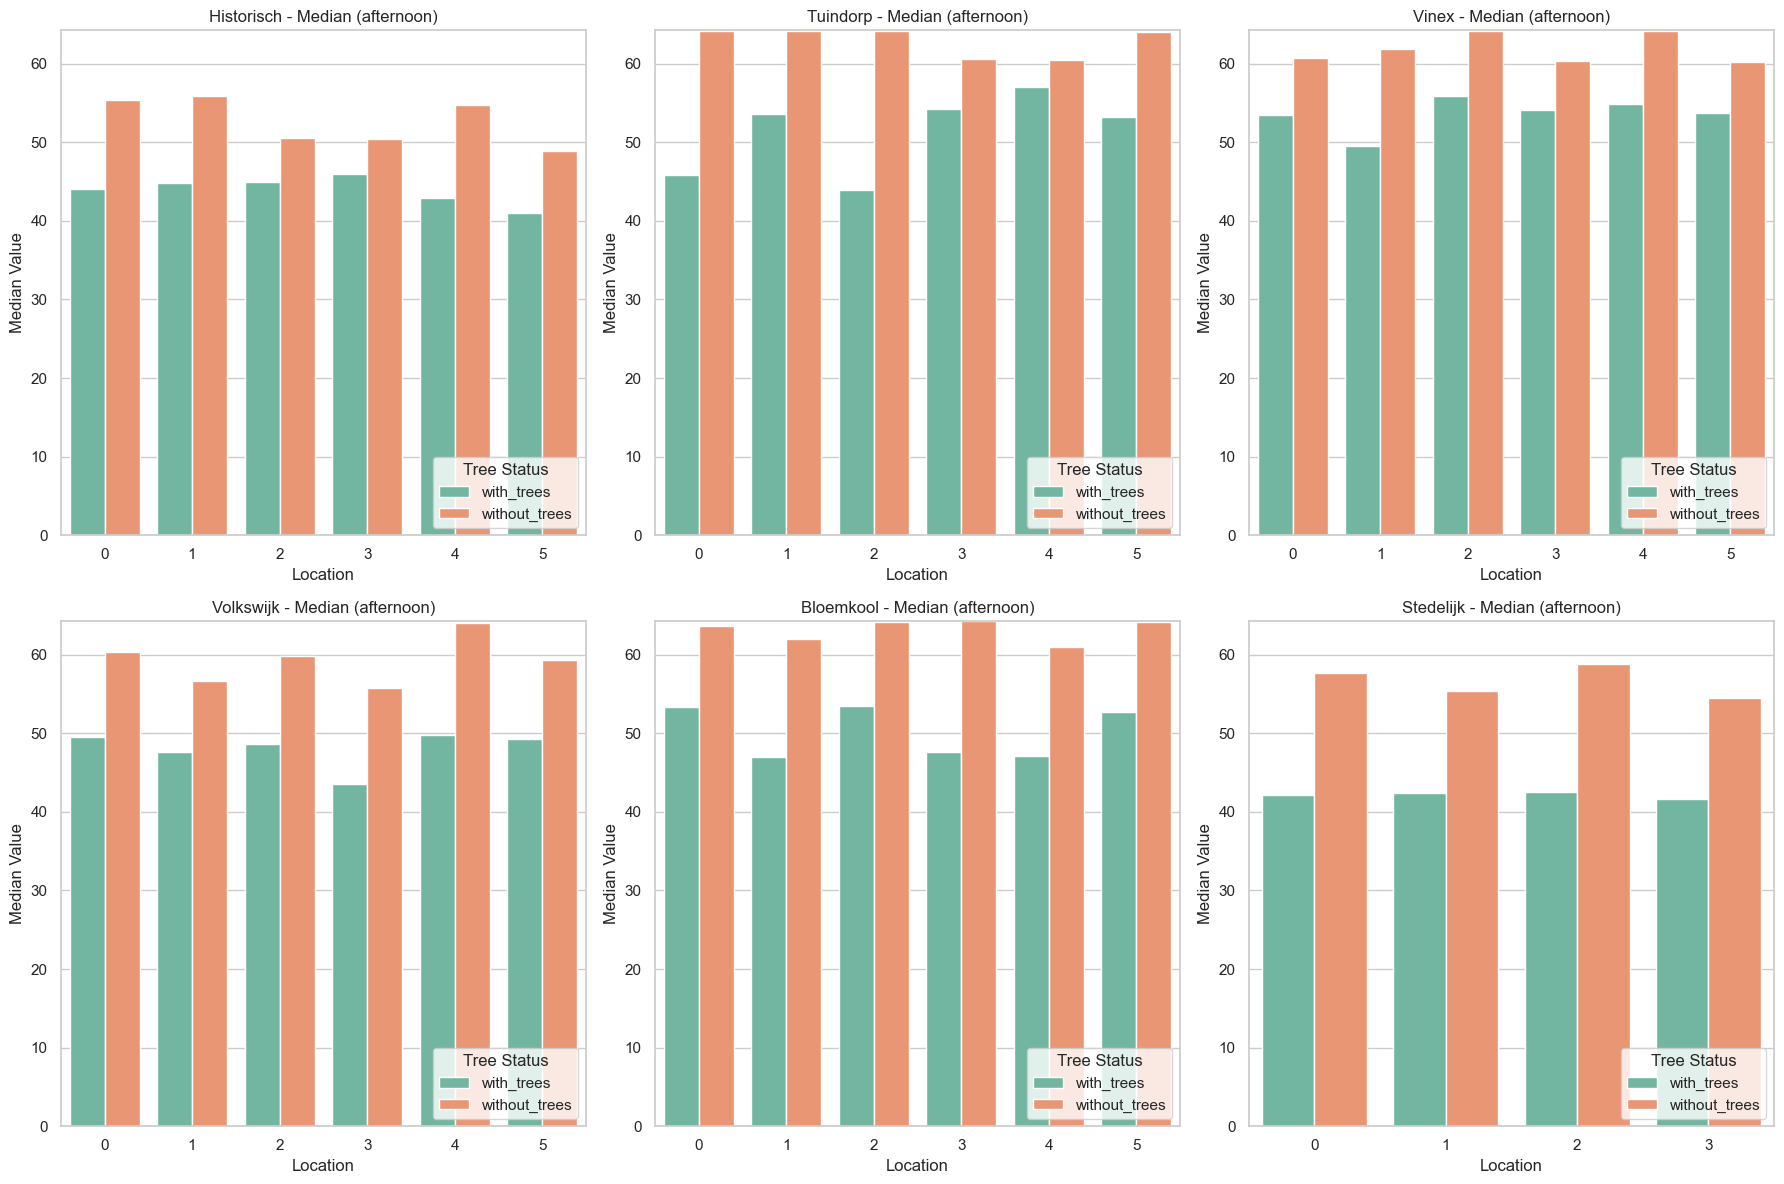

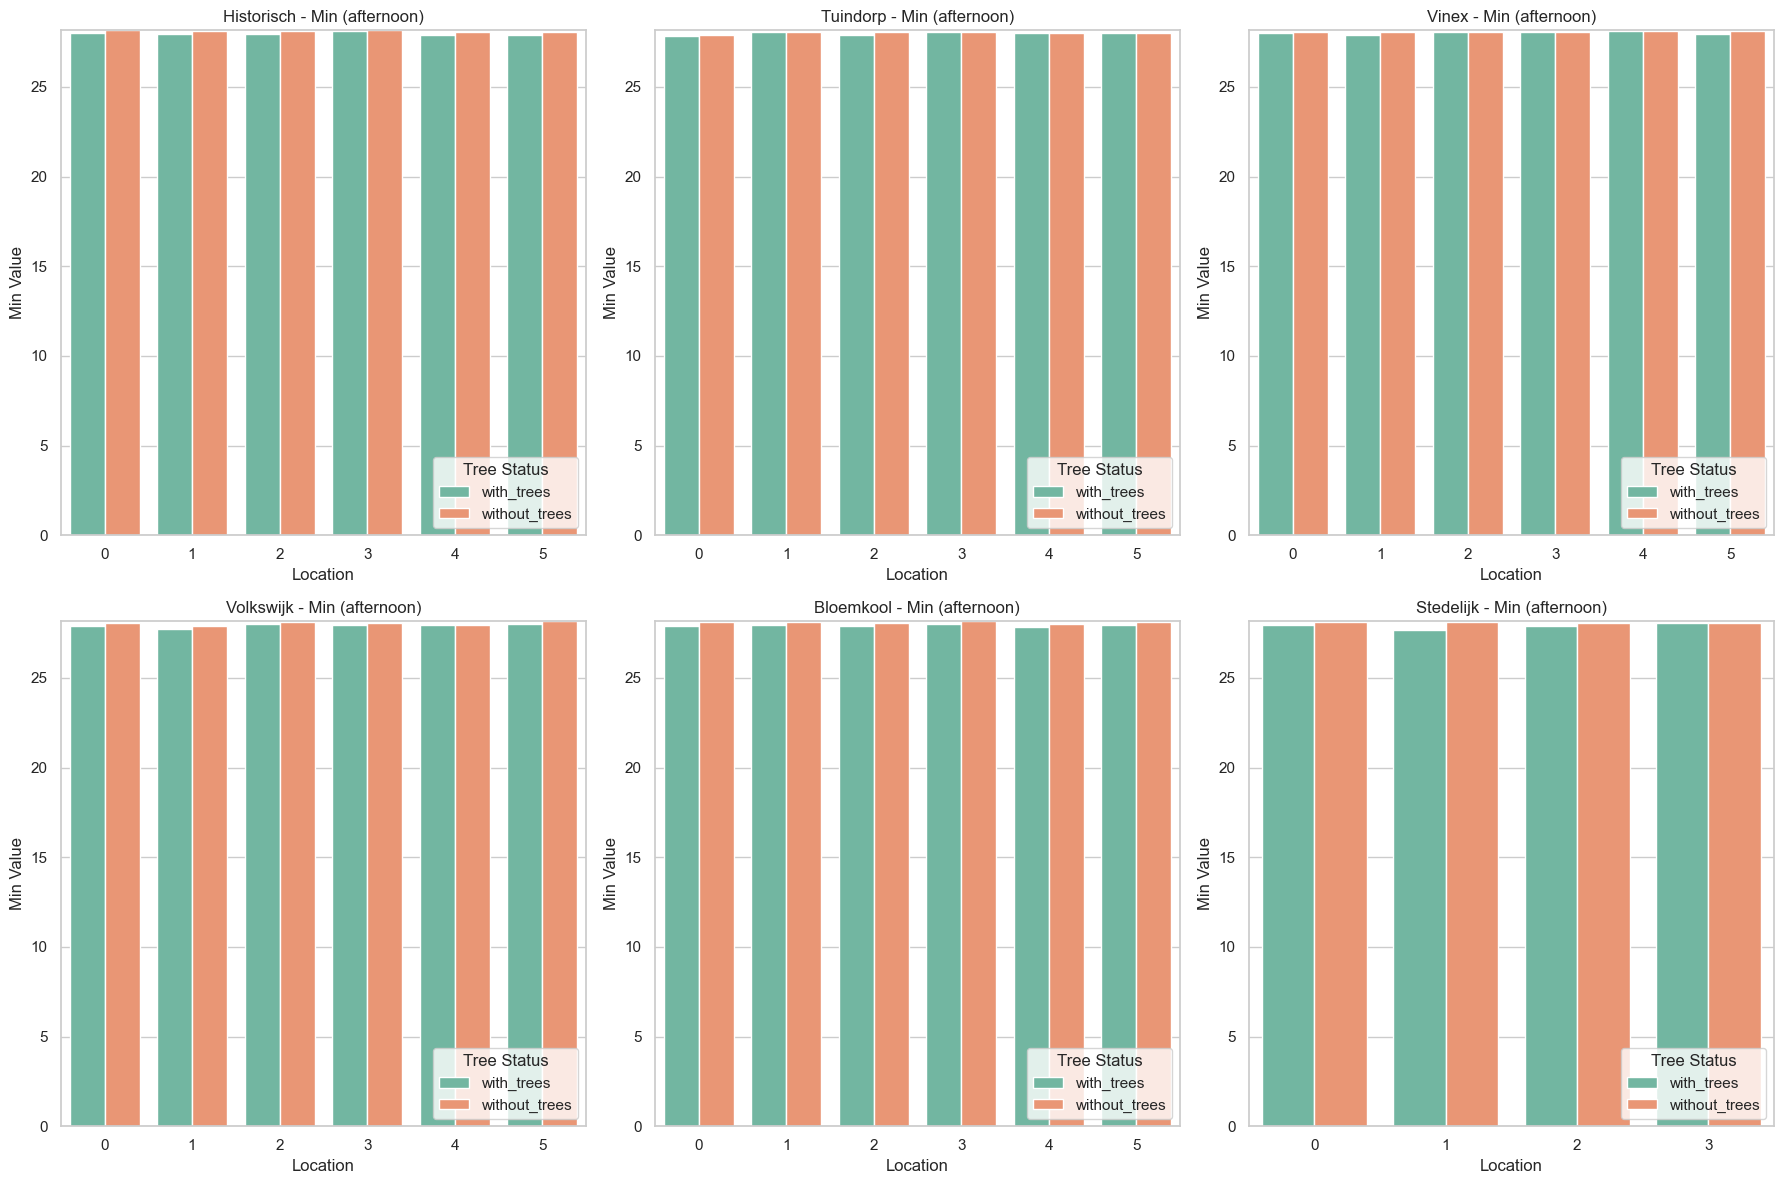

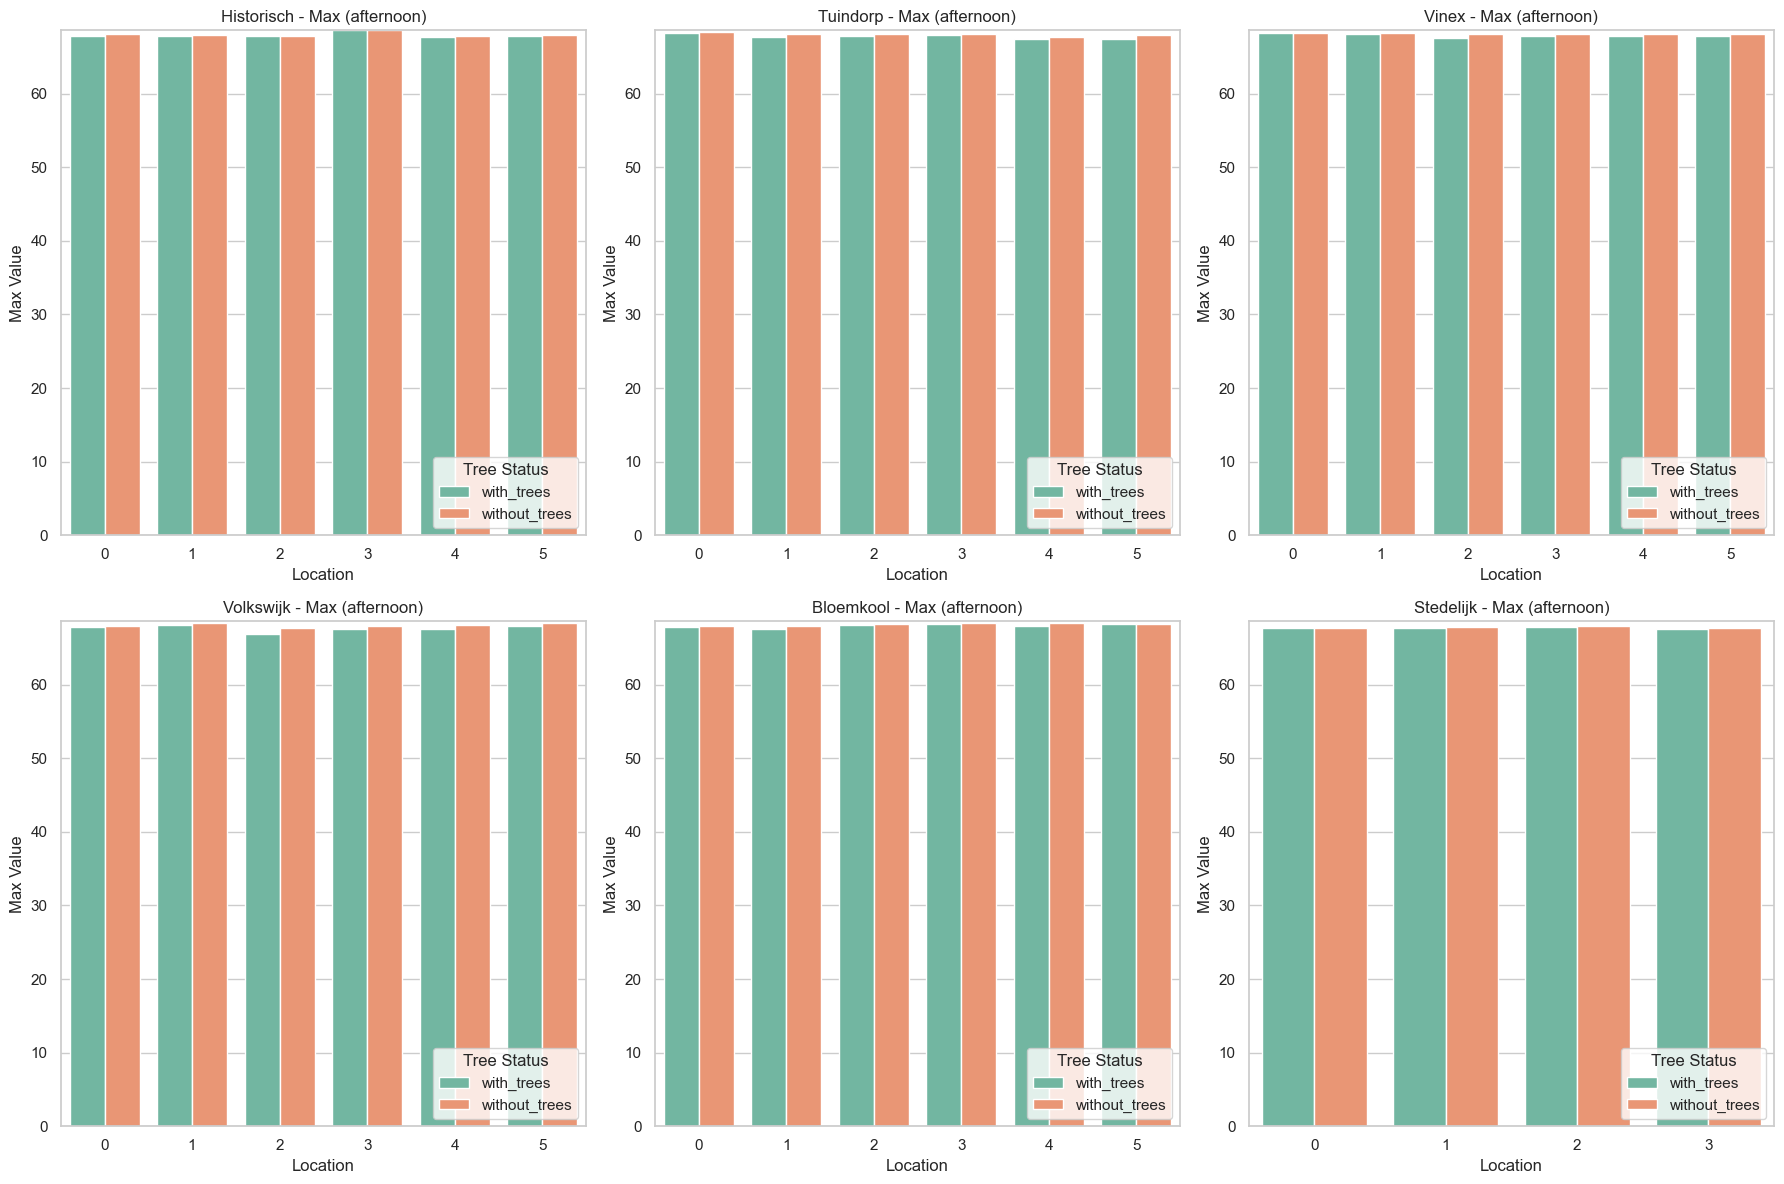

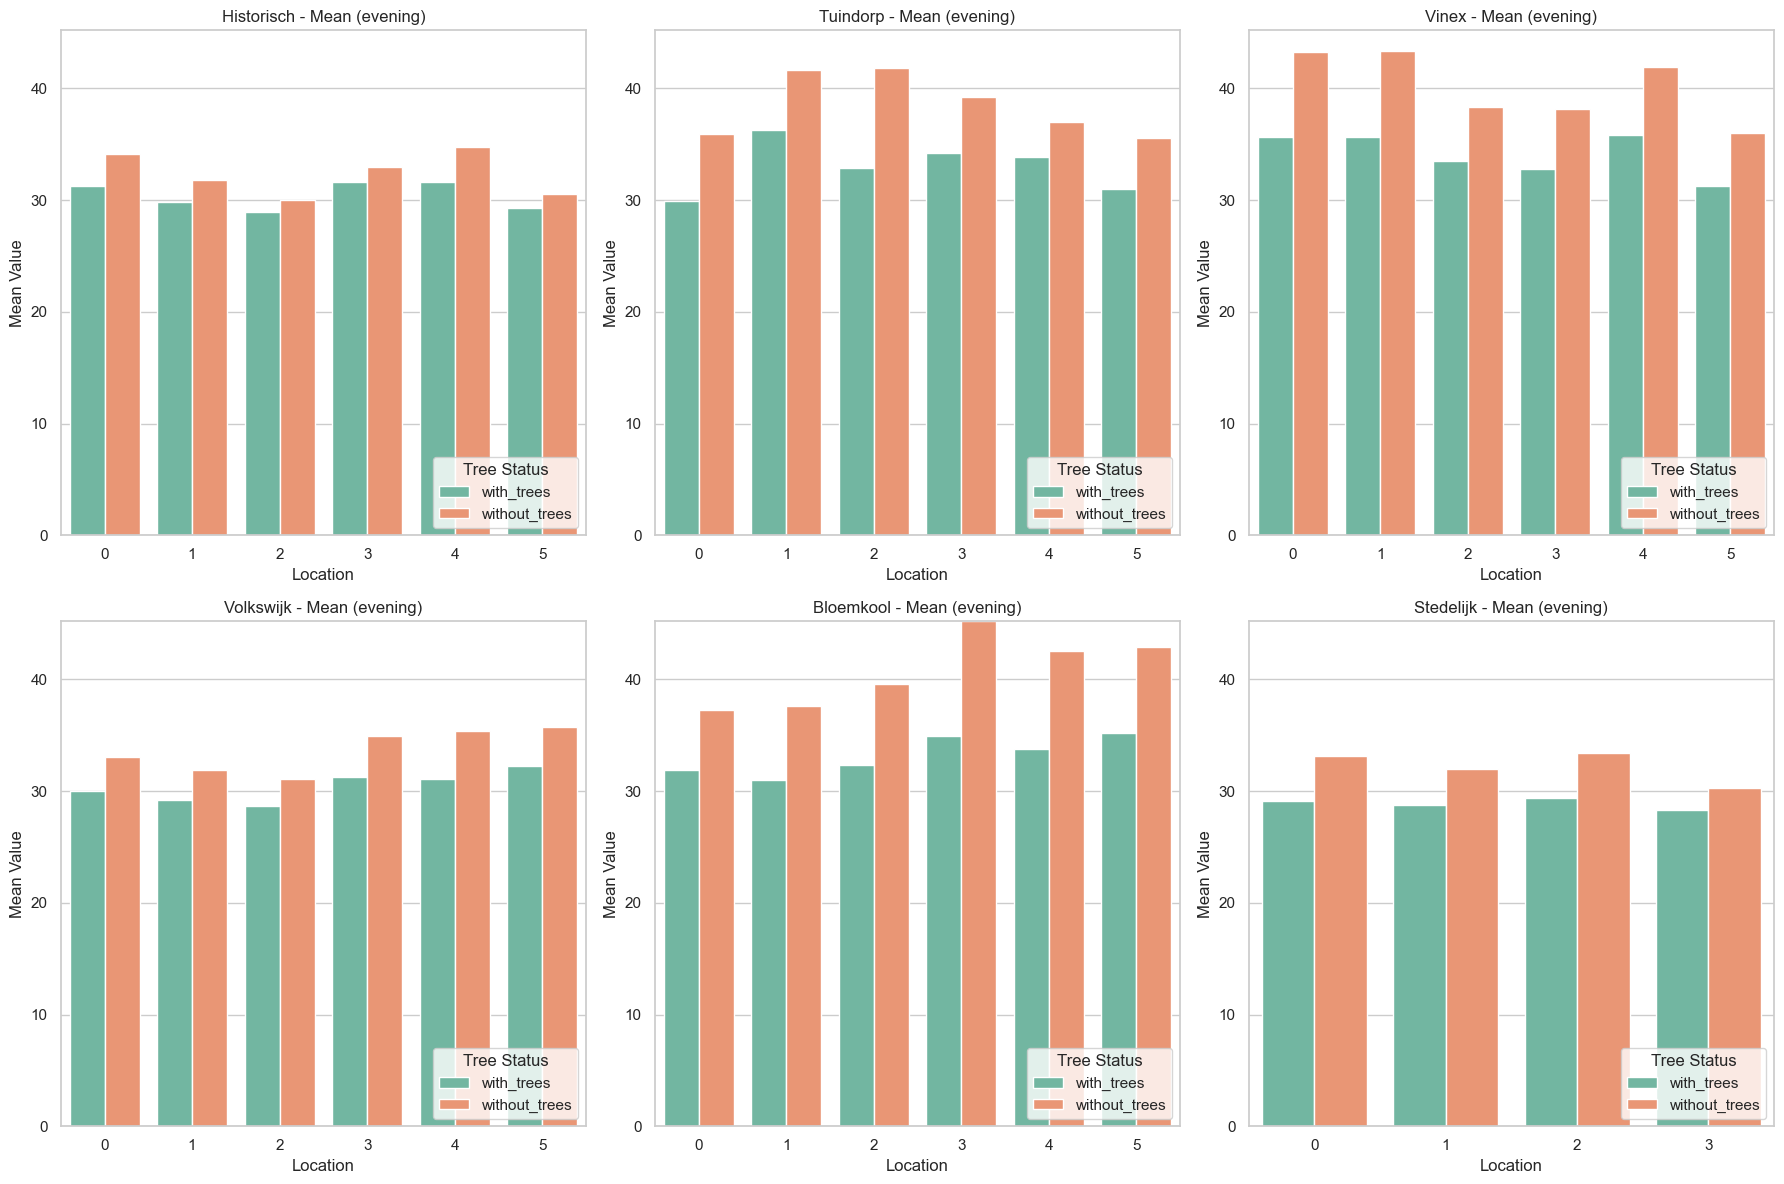

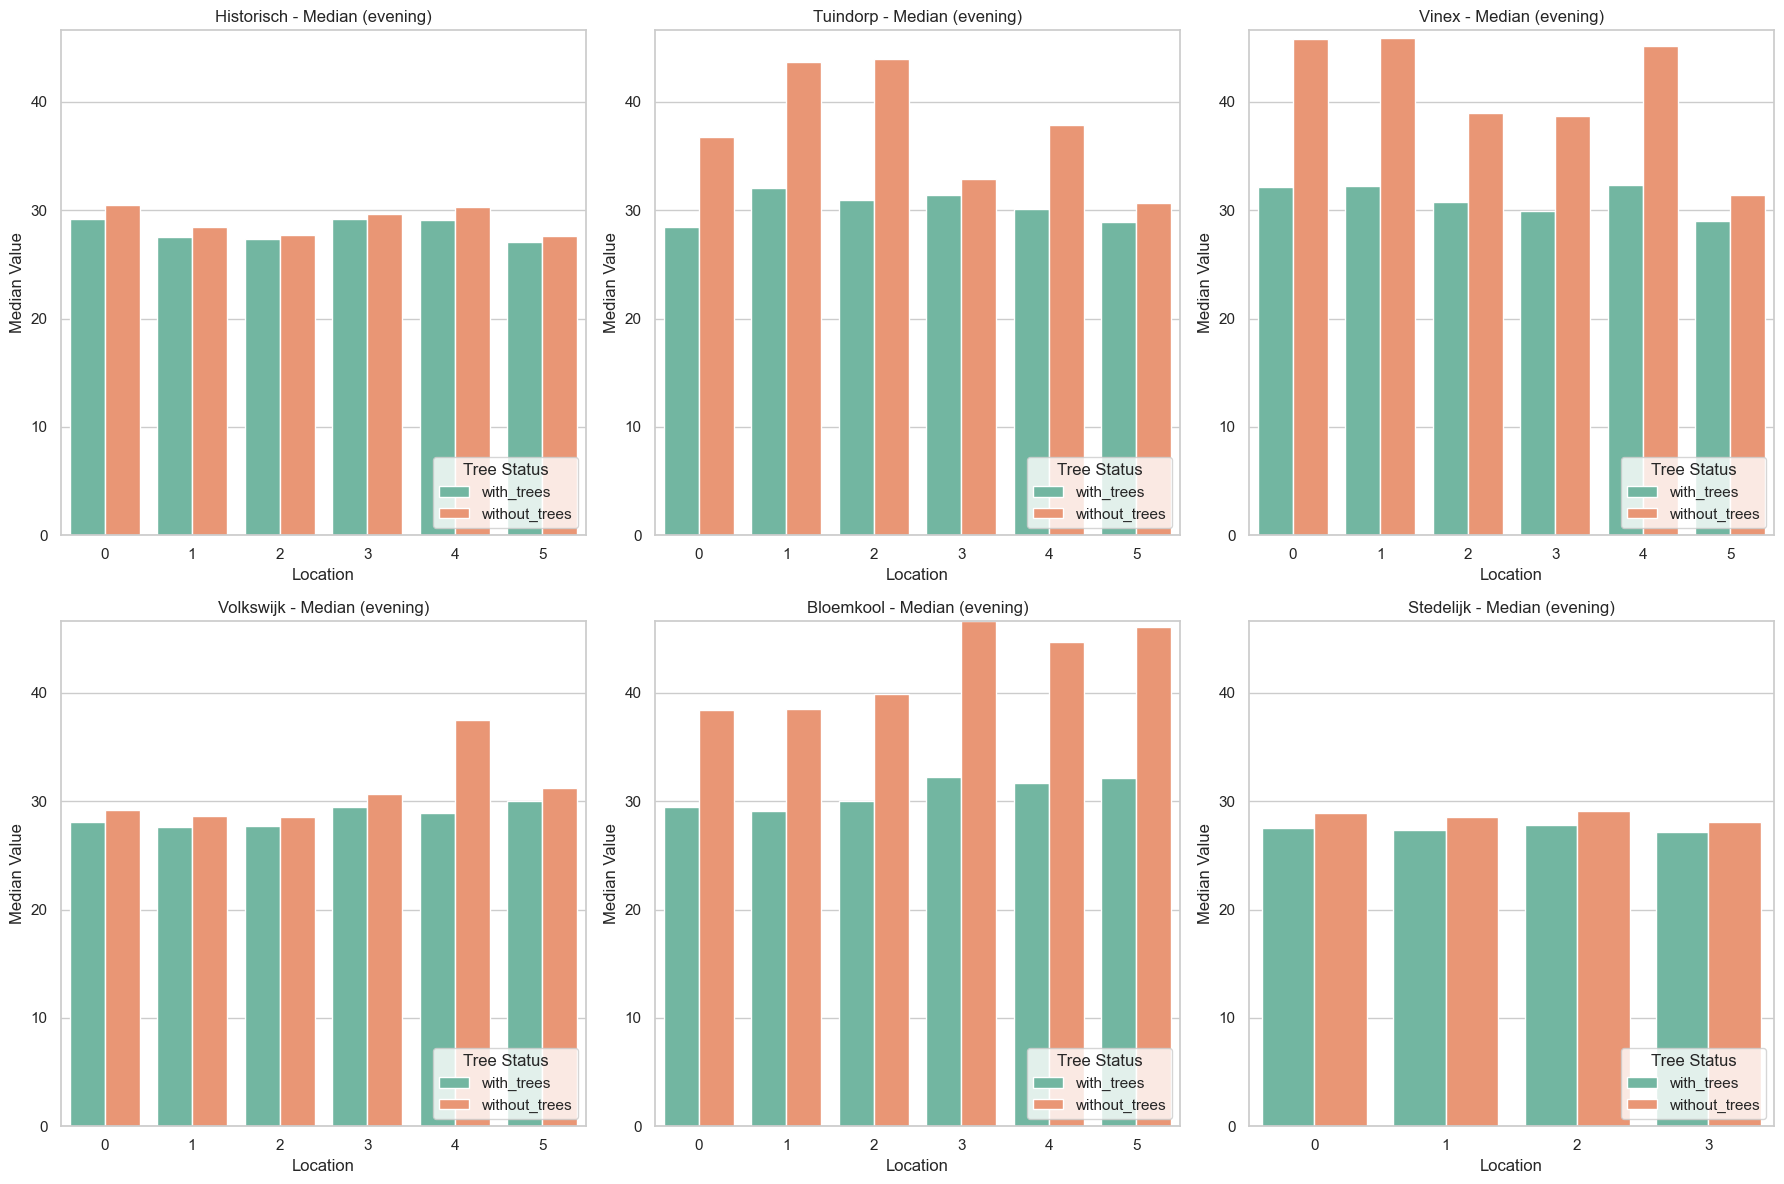

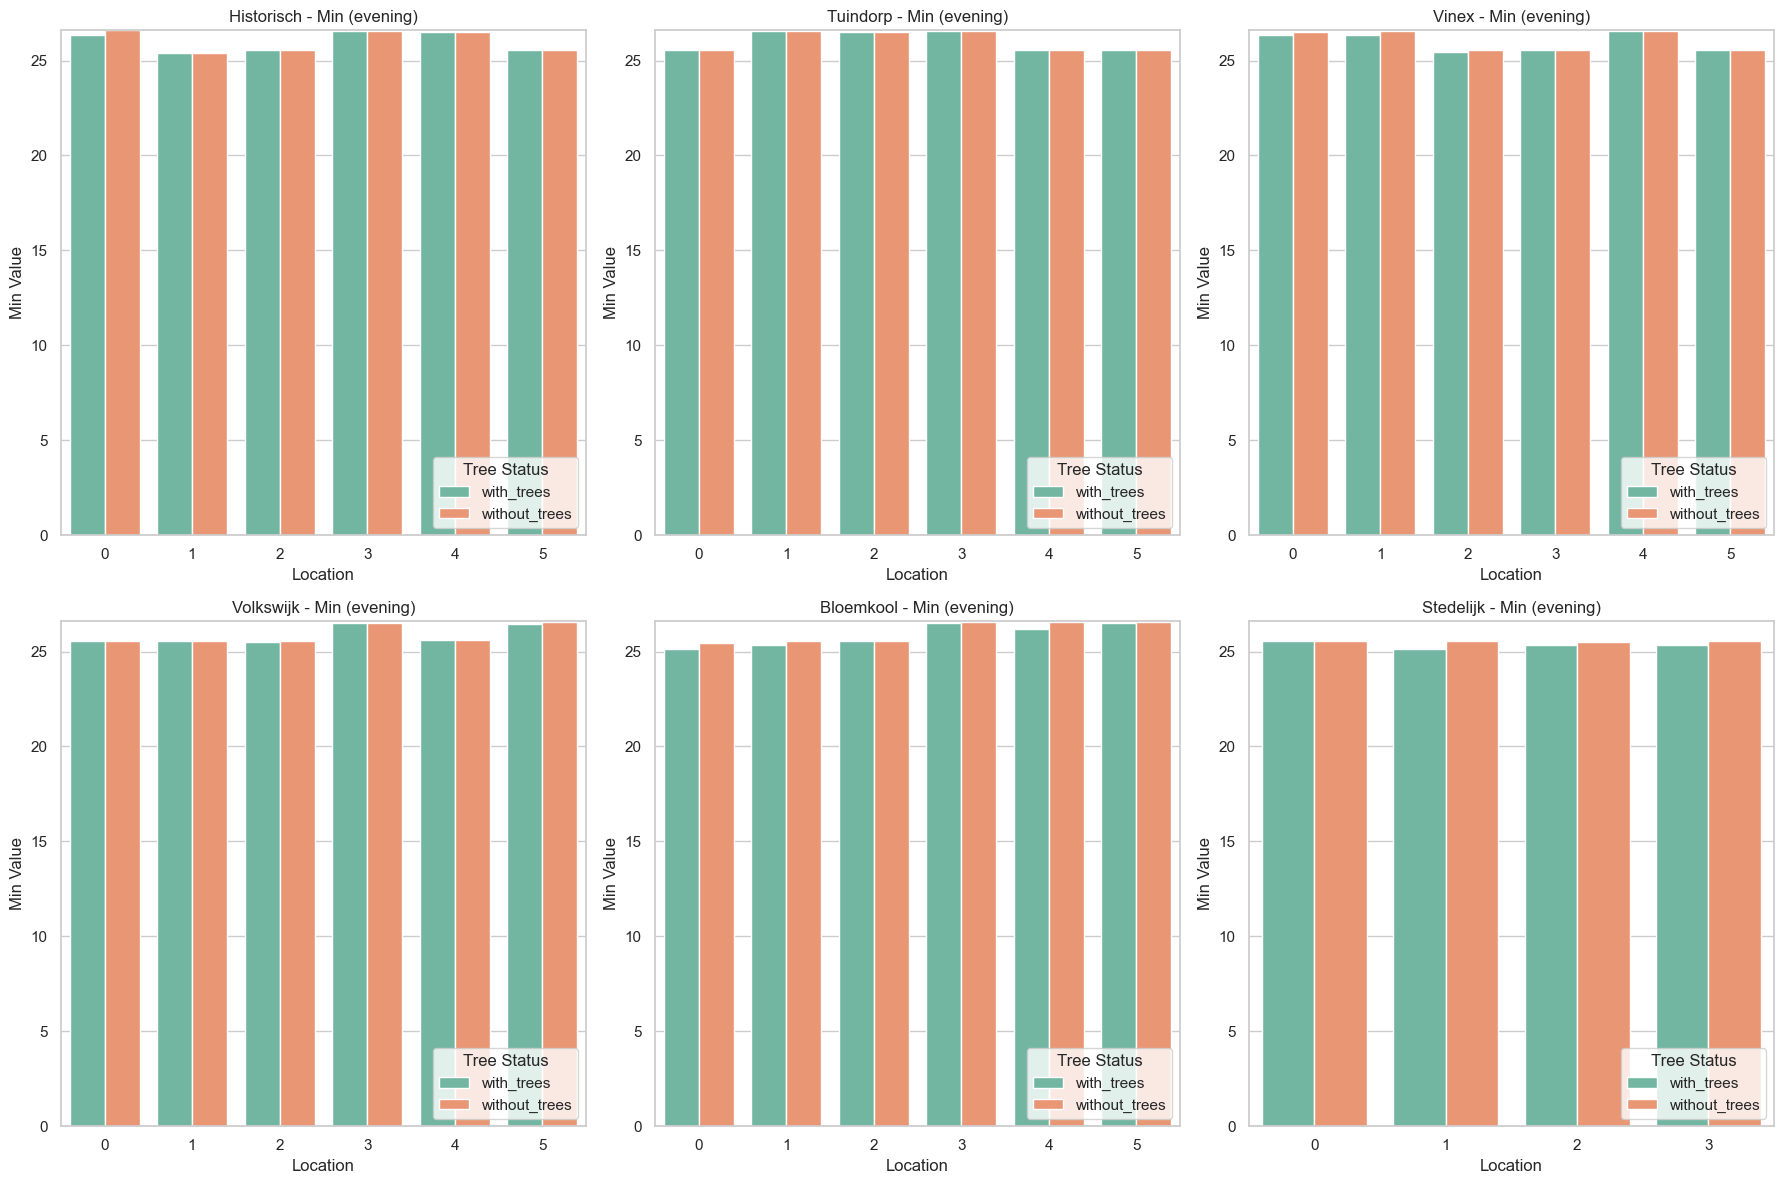

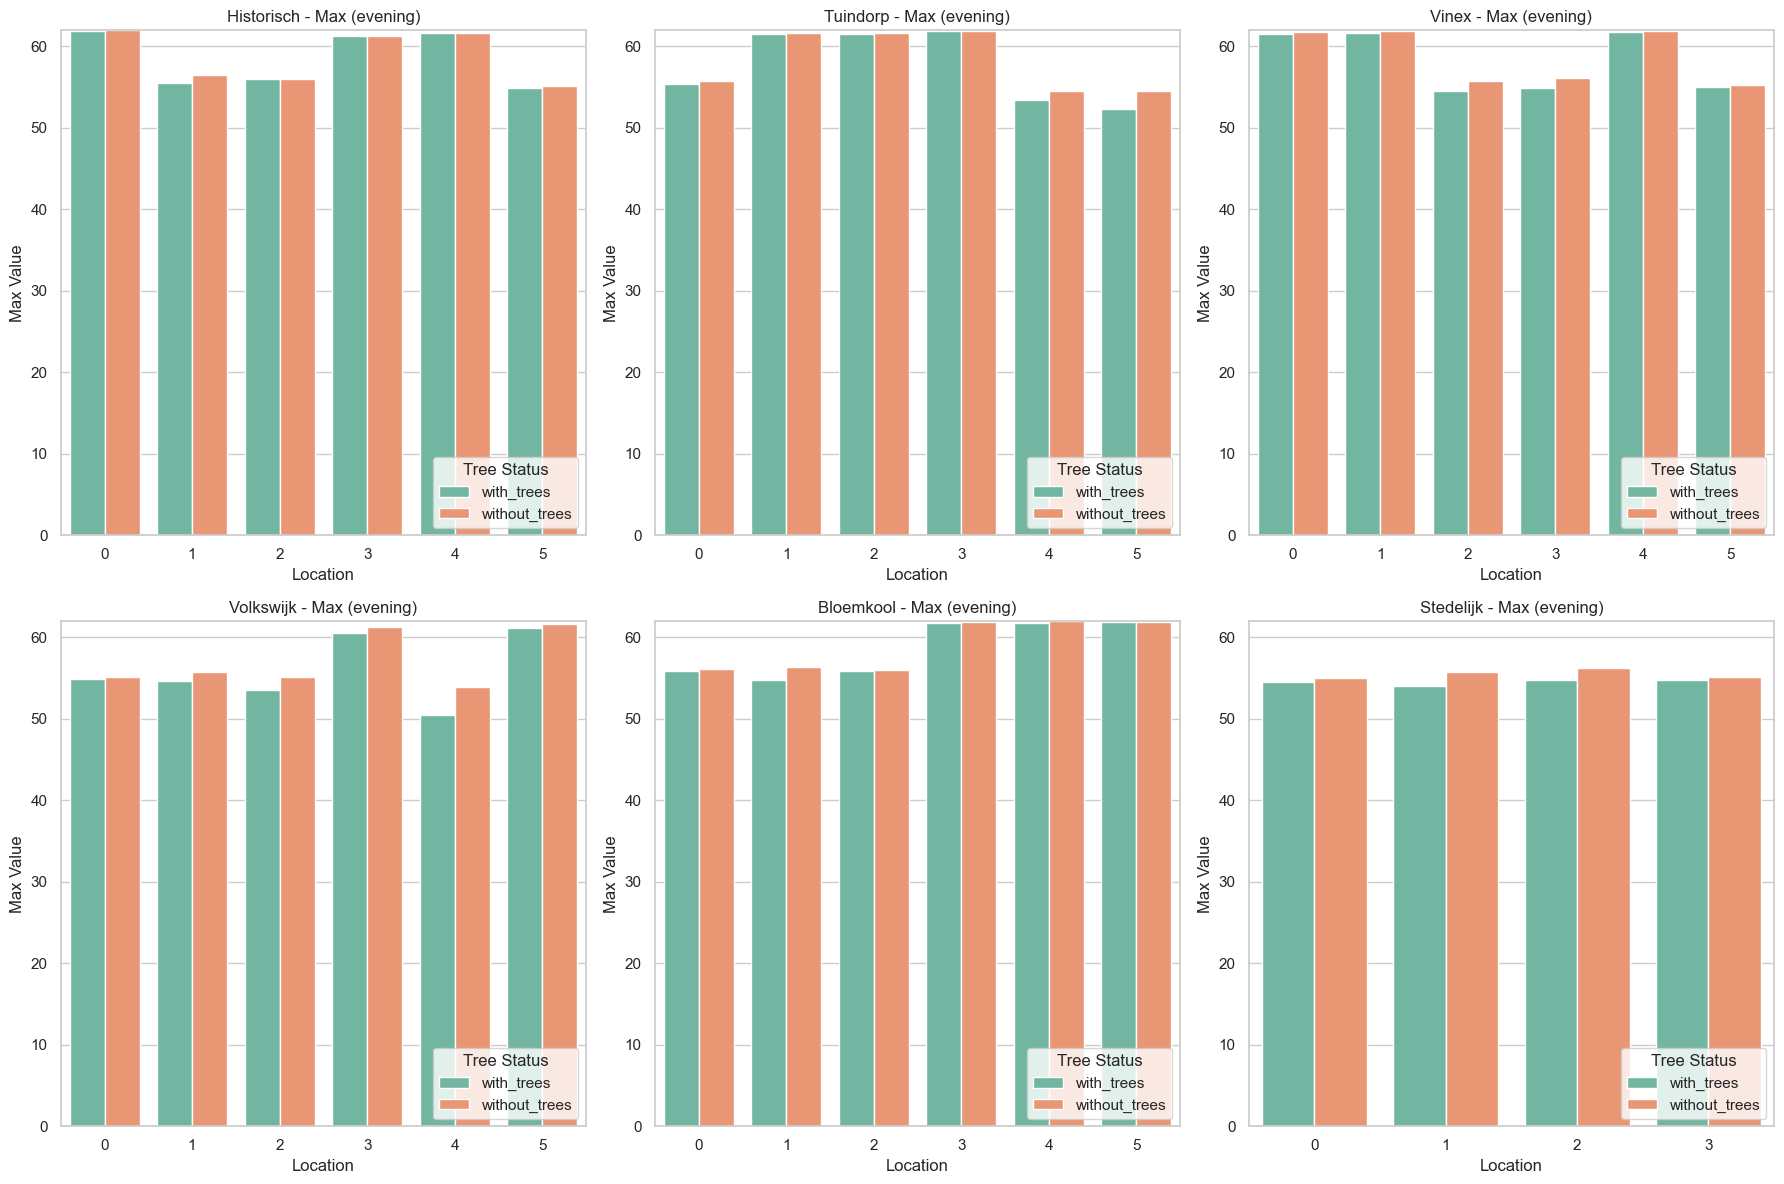

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Day type to filter
day = 'avg'

# Time periods to loop over
time_periods = ['morning', 'afternoon', 'evening']

# Stats to compare
stats = ['mean', 'median', 'min', 'max']

# Adjust for 'stedelijk' typology to only consider the first 4 locations
locs_to_plot = {typ: locs if typ != 'stedelijk' else locs[:4] for typ in typologies}

# Loop through each time period
for time_period in time_periods:
    for stat in stats:
        # --- Compute the global max value for this stat and time_period ---
        df_subset = df_all[
            (df_all['avg_or_ext'] == day) &
            (df_all['time'] == time_period)
        ]

        max_y = df_subset[stat].max()

        # Create a figure with 2 columns and 3 rows
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        for idx, typ in enumerate(typologies):
            df_typology = df_subset[df_subset['typology'] == typ]

            plot_data = []
            locs_for_typology = locs_to_plot[typ]

            for loc in locs_for_typology:
                data_with_trees = df_typology[
                    (df_typology['location'] == loc) &
                    (df_typology['without_trees'] == False)
                ][stat]

                data_without_trees = df_typology[
                    (df_typology['location'] == loc) &
                    (df_typology['without_trees'] == True)
                ][stat]

                plot_data.append({
                    'location': loc,
                    'tree_status': 'with_trees',
                    'value': data_with_trees.mean() if not data_with_trees.empty else None
                })
                plot_data.append({
                    'location': loc,
                    'tree_status': 'without_trees',
                    'value': data_without_trees.mean() if not data_without_trees.empty else None
                })
            plot_df = pd.DataFrame(plot_data)
            ax = axes[idx]
            sns.barplot(
                x='location', y='value', hue='tree_status',
                data=plot_df, errorbar=None, palette="Set2",
                dodge=True, ax=ax
            )

            ax.set_title(f"{typ.capitalize()} - {stat.capitalize()} ({time_period})")
            ax.set_xlabel('Location')
            ax.set_ylabel(f'{stat.capitalize()} Value')
            ax.set_xticks(range(len(locs_for_typology)))
            ax.set_xticklabels([f'{i}' for i in locs_for_typology])
            ax.set_ylim(0, max_y)  # Apply shared y-axis limit
            ax.legend(title='Tree Status', loc='lower right', bbox_to_anchor=(1, 0))

        # Remove unused subplots if necessary
        for j in range(len(typologies), len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()

        # Save the plot
        output_file = f"plots/{stat}_comparison_plot_{time_period}_{day}.png"
        plt.savefig(output_file)
        print(f"Saved plot as {output_file}")

        # plt.show()

[{'typology': 'historisch', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 35.56295772222222, 'without_trees_avg': 39.39394405555555, 'with_trees_std': 1.1103356867137164, 'without_trees_std': 1.6634717632958023}, {'typology': 'tuindorp', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 38.79994338888889, 'without_trees_avg': 44.95180916666667, 'with_trees_std': 2.4050513685107293, 'without_trees_std': 1.2074392183676992}, {'typology': 'vinex', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 39.81669405555556, 'without_trees_avg': 45.90241316666667, 'with_trees_std': 1.4118359861865823, 'without_trees_std': 1.3142103741847535}, {'typology': 'volkswijk', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 36.874310722222226, 'without_trees_avg': 41.87073388888889, 'with_trees_std': 1.2428480453428044, 'without_trees_std': 1.3504962105928404}, {'typology': 'bloemkool', 'stat': 'mean', 'time': 'overall', 'with_trees_avg': 38.44278861111111, 'without_trees_avg': 46.37658288

C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

Saved plot as plots/stat_typology_comparison_mean_avg.png


C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

Saved plot as plots/stat_typology_comparison_median_avg.png


C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

Saved plot as plots/stat_typology_comparison_min_avg.png


C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data['typology'], rotation=45, ha='right')
C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\4136709101.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

Saved plot as plots/stat_typology_comparison_max_avg.png
Saved summary DataFrame to summary_statistics_avg.csv


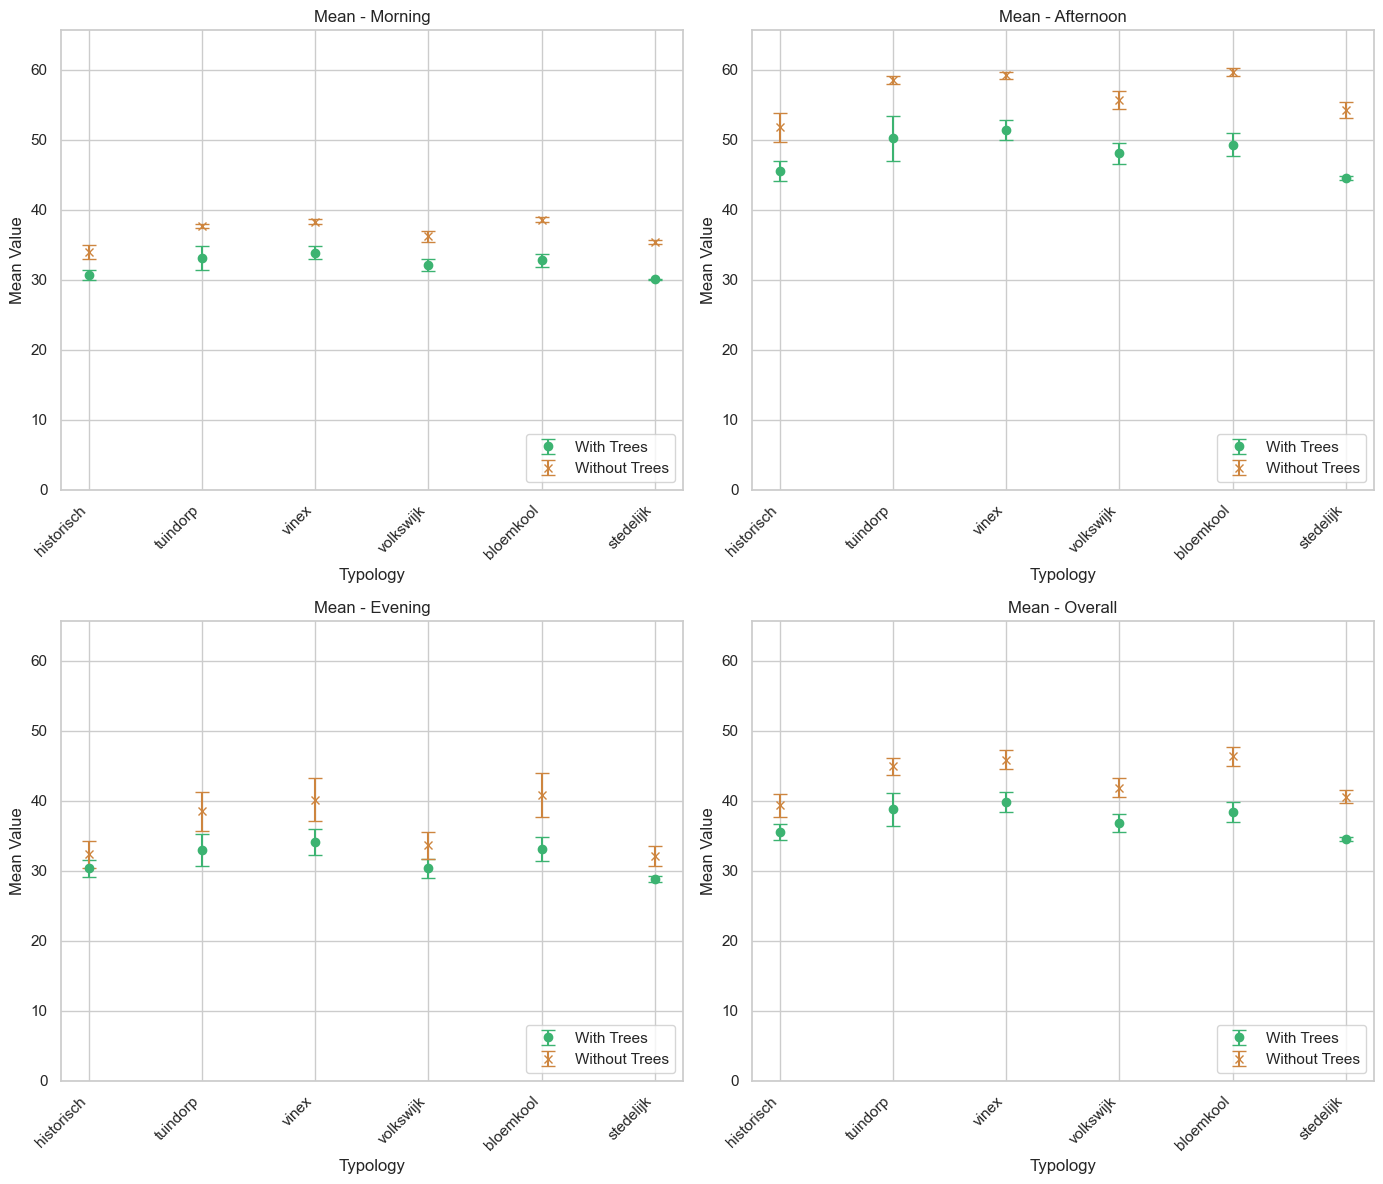

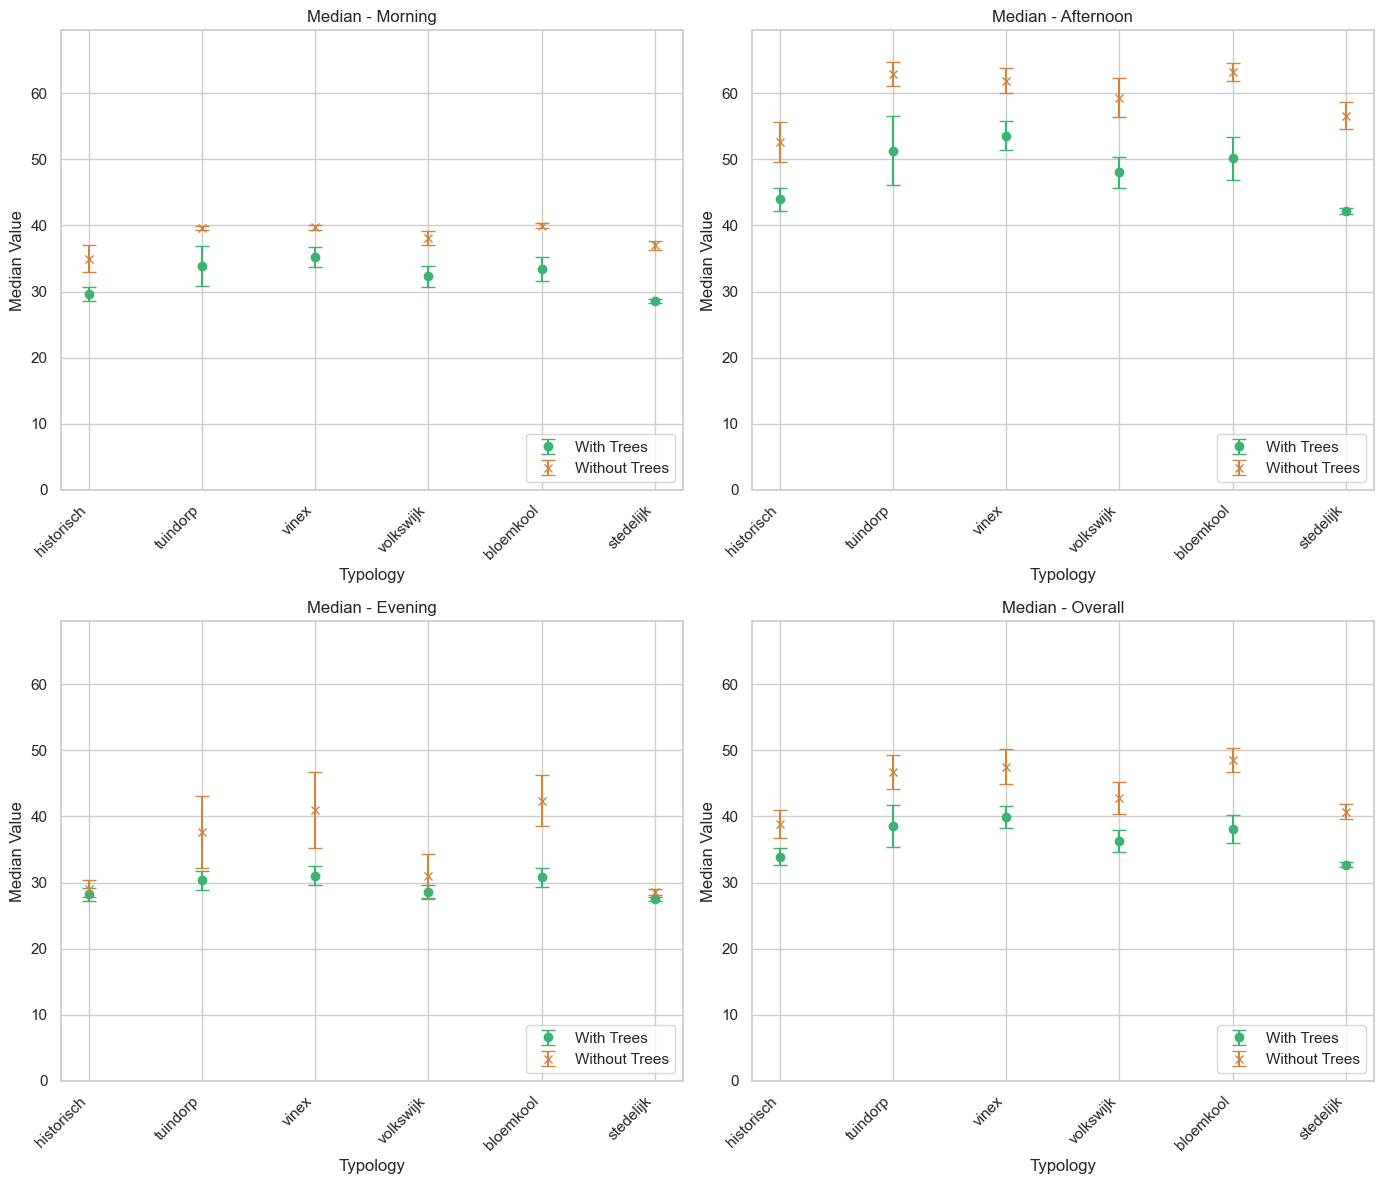

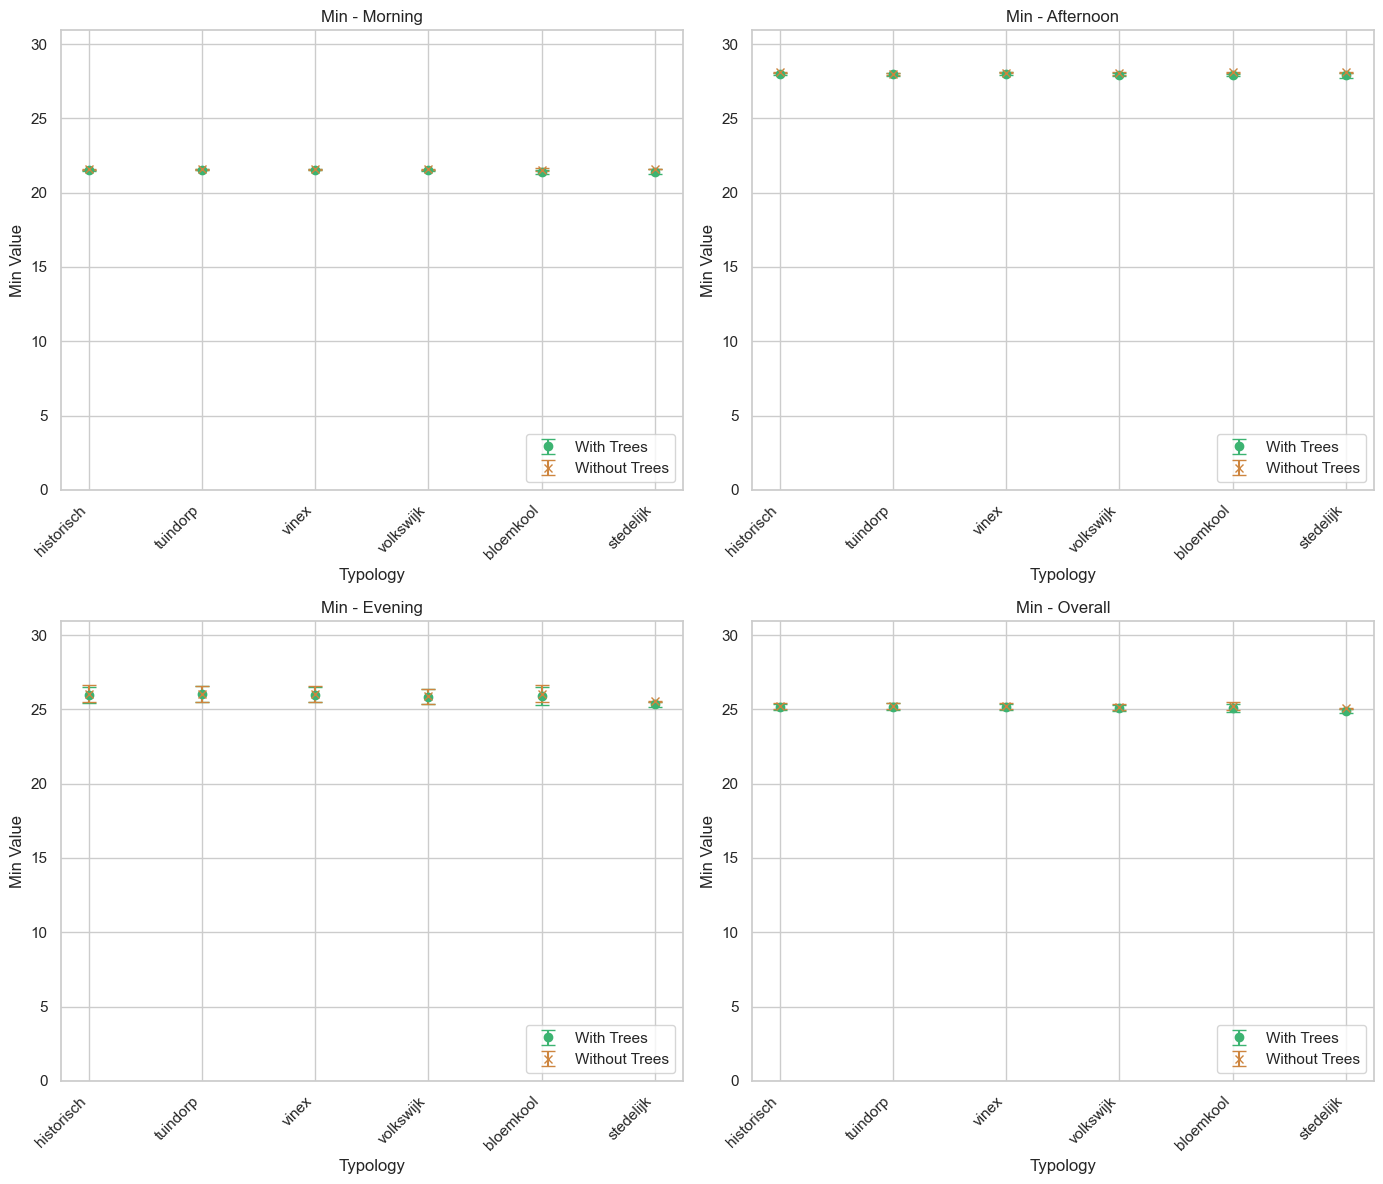

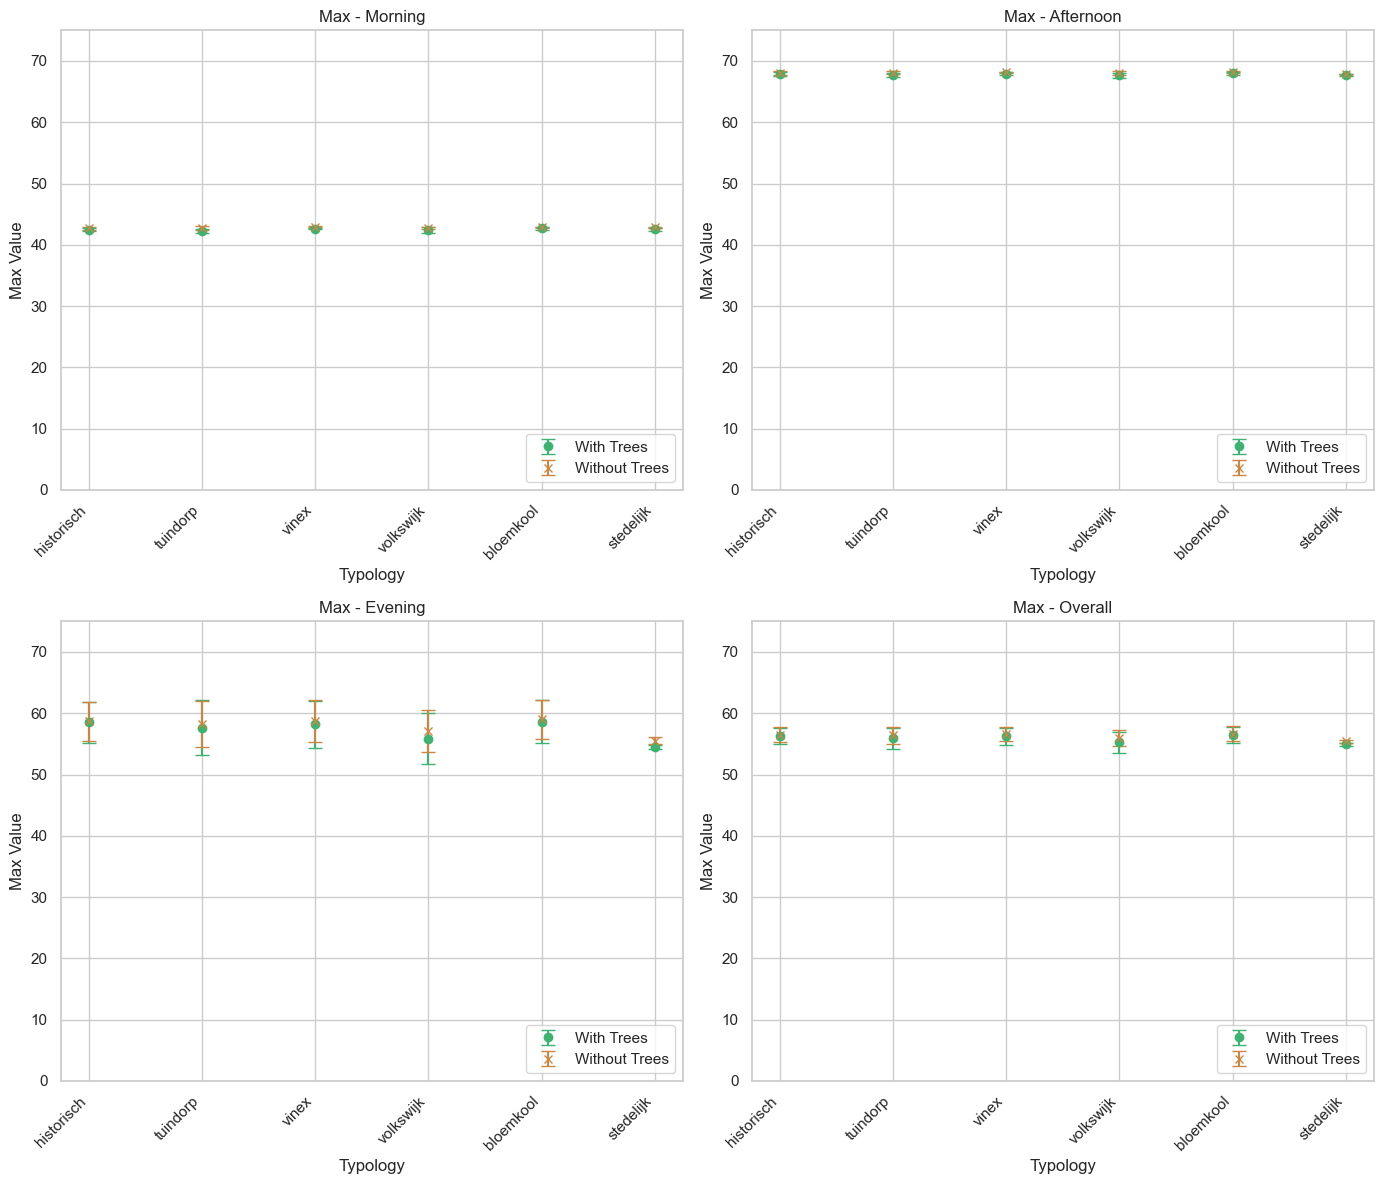

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Stats, time periods, typologies
stats = ['mean', 'median', 'min', 'max']
time_periods = ['morning', 'afternoon', 'evening']
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']

summary_data = []

# Compute summary values for each typology, time, and stat
for stat in stats:
    for typ in typologies:
        for time in time_periods:
            df_typology = df_all[
                (df_all['typology'] == typ) &
                (df_all['avg_or_ext'] == day) &
                (df_all['time'] == time)
            ]
            with_trees_vals = []
            without_trees_vals = []

            for loc in locs:
                data_with_trees = df_typology[
                    (df_typology['location'] == loc) &
                    (df_typology['without_trees'] == False)
                ][stat]

                data_without_trees = df_typology[
                    (df_typology['location'] == loc) &
                    (df_typology['without_trees'] == True)
                ][stat]

                with_trees_vals.append(data_with_trees.mean() if not data_with_trees.empty else None)
                without_trees_vals.append(data_without_trees.mean() if not data_without_trees.empty else None)

            avg_with = pd.Series(with_trees_vals).mean()
            std_with = pd.Series(with_trees_vals).std()
            avg_without = pd.Series(without_trees_vals).mean()
            std_without = pd.Series(without_trees_vals).std()

            summary_data.append({
                'typology': typ,
                'stat': stat,
                'time': time,
                'with_trees_avg': avg_with,
                'without_trees_avg': avg_without,
                'with_trees_std': std_with,
                'without_trees_std': std_without,
            })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Calculate the 'overall' values, which depend on the `day` parameter
average_rows = []
for stat in stats:
    for typ in typologies:
        # Subset the data based on the current typology and stat
        sub = summary_df[(summary_df['typology'] == typ) & (summary_df['stat'] == stat)]
        # For 'avg' day type: take the average of 'morning', 'afternoon', 'evening'
        # For 'ext' day type: do the same, but based on the specific day data
        sub_day = sub[sub['time'].isin(time_periods)]

        avg_with = sub_day['with_trees_avg'].mean()
        std_with = sub_day['with_trees_std'].mean()
        avg_without = sub_day['without_trees_avg'].mean()
        std_without = sub_day['without_trees_std'].mean()


        # Add an 'overall' row to the summary data
        average_rows.append({
            'typology': typ,
            'stat': stat,
            'time': 'overall',
            'with_trees_avg': avg_with,
            'without_trees_avg': avg_without,
            'with_trees_std': std_with,
            'without_trees_std': std_without
        })
print(average_rows)
summary_df = pd.concat([summary_df, pd.DataFrame(average_rows)], ignore_index=True)
print(summary_df)

# --- PLOTTING ---
for stat in stats:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    # Determine global y-axis limits for this stat
    stat_subset = summary_df[summary_df['stat'] == stat]
    all_values = pd.concat([
        stat_subset['with_trees_avg'],
        stat_subset['without_trees_avg']
    ])
    global_ymin = 0  # Always start from 0
    global_ymax = all_values.max() * 1.1  # Add 10% padding

    # Loop over time periods including the 'overall' calculated for the given `day` type
    for i, time in enumerate(time_periods + ['overall']):
        ax = axes[i]

        # Filter by 'overall' which is dependent on the `day` value
        if time == 'overall':
            data = stat_subset[stat_subset['time'] == 'overall']
        else:
            data = stat_subset[stat_subset['time'] == time]

        ax.errorbar(data['typology'], data['with_trees_avg'],
                    yerr=data['with_trees_std'], fmt='o', label='With Trees',
                    capsize=5, color='mediumseagreen', linestyle='None')

        ax.errorbar(data['typology'], data['without_trees_avg'],
                    yerr=data['without_trees_std'], fmt='x', label='Without Trees',
                    capsize=5, color='peru', linestyle='None')

        ax.set_title(f"{stat.capitalize()} - {time.capitalize()}")
        ax.set_xlabel("Typology")
        ax.set_ylabel(f"{stat.capitalize()} Value")
        ax.set_xticklabels(data['typology'], rotation=45, ha='right')
        ax.set_ylim(global_ymin, global_ymax)
        ax.legend(loc='lower right')

    plt.tight_layout()
    output_file = f"plots/stat_typology_comparison_{stat}_{day}.png"
    plt.savefig(output_file)
    print(f"Saved plot as {output_file}")
    # plt.show()
summary_df.to_csv(f"outputstats/summary_statistics_{day}.csv", index=False)
print(f"Saved summary DataFrame to summary_statistics_{day}.csv")

In [21]:
average_diff_data = []

for stat in stats:
    for typ in typologies:
        for time in time_periods:
            # Filter for current typology, time period, and extreme days
            df_typology = df_all[
                (df_all['typology'] == typ) &
                (df_all['avg_or_ext'] == day) &
                (df_all['time'] == time)
            ]

            location_diffs = []
            for loc in locs:
                data_with = df_typology[(df_typology['location'] == loc) & (df_typology['without_trees'] == False)][stat]
                data_without = df_typology[(df_typology['location'] == loc) & (df_typology['without_trees'] == True)][stat]

                if not data_with.empty and not data_without.empty:
                    diff = data_with.mean() - data_without.mean()
                    location_diffs.append(diff)

            avg_diff = pd.Series(location_diffs).mean() if location_diffs else None

            average_diff_data.append({
                'typology': typ,
                'stat': stat,
                'time': time,
                'average_difference': avg_diff
            })

# Add overall differences based on summary_df
for stat in stats:
    for typ in typologies:
        overall_row = summary_df[
            (summary_df['typology'] == typ) &
            (summary_df['stat'] == stat) &
            (summary_df['time'] == 'overall')
        ]

        if not overall_row.empty:
            avg_with = overall_row['with_trees_avg'].values[0]
            avg_without = overall_row['without_trees_avg'].values[0]
            avg_diff = avg_with - avg_without

            average_diff_data.append({
                'typology': typ,
                'stat': stat,
                'time': 'overall',
                'average_difference': avg_diff
            })

# Convert to DataFrame and sort
average_diff_df = pd.DataFrame(average_diff_data)
average_diff_df['time'] = pd.Categorical(average_diff_df['time'], categories=time_periods + ['overall'], ordered=True)
average_diff_df = average_diff_df.sort_values(by=['stat', 'typology', 'time'])

# Print results
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    print("\n--- AVERAGE TEMPERATURE IMPROVEMENT WITH TREES (per location) ---")
    print(average_diff_df)




--- AVERAGE TEMPERATURE IMPROVEMENT WITH TREES (per location) ---
      typology    stat       time  average_difference
66   bloemkool     max    morning           -0.129742
67   bloemkool     max  afternoon           -0.197334
68   bloemkool     max    evening           -0.406892
94   bloemkool     max    overall           -0.244656
54  historisch     max    morning           -0.237689
55  historisch     max  afternoon           -0.143542
56  historisch     max    evening           -0.213534
90  historisch     max    overall           -0.198255
69   stedelijk     max    morning           -0.328794
70   stedelijk     max  afternoon           -0.121173
71   stedelijk     max    evening           -1.046510
95   stedelijk     max    overall           -0.498826
57    tuindorp     max    morning           -0.444167
58    tuindorp     max  afternoon           -0.329128
59    tuindorp     max    evening           -0.641824
91    tuindorp     max    overall           -0.471706
60       vinex 

In [22]:
pivot_df = average_diff_df.pivot_table(
    index='typology',
    columns=['stat', 'time'],
    values='average_difference'
).round(2)  # round for LaTeX presentation

# Ensure all columns are present and in desired order
stats = ['mean', 'median', 'min', 'max']
time_order = ['morning', 'afternoon', 'evening', 'overall']
columns_order = [(s, t) for s in stats for t in time_order]
pivot_df = pivot_df.reindex(columns=pd.MultiIndex.from_tuples(columns_order))

# Generate LaTeX rows
latex_rows = ""
for typ in pivot_df.index:
    row = [typ] + [f"{pivot_df.loc[typ, (stat, time)]:.2f}" if pd.notna(pivot_df.loc[typ, (stat, time)]) else "-"
                   for stat in stats for time in time_order]
    latex_rows += " & ".join(row) + r" \\" + "\n"

print(latex_rows)

bloemkool & -5.82 & -10.35 & -7.64 & -7.93 & -6.58 & -13.00 & -11.61 & -10.40 & -0.13 & -0.17 & -0.16 & -0.16 & -0.13 & -0.20 & -0.41 & -0.24 \\
historisch & -3.34 & -6.21 & -1.94 & -3.83 & -5.40 & -8.69 & -0.83 & -4.97 & -0.07 & -0.14 & -0.06 & -0.09 & -0.24 & -0.14 & -0.21 & -0.20 \\
stedelijk & -5.35 & -9.74 & -3.28 & -6.12 & -8.48 & -14.41 & -1.15 & -8.01 & -0.14 & -0.19 & -0.21 & -0.18 & -0.33 & -0.12 & -1.05 & -0.50 \\
tuindorp & -4.59 & -8.35 & -5.52 & -6.15 & -5.72 & -11.61 & -7.30 & -8.21 & -0.02 & -0.04 & -0.01 & -0.02 & -0.44 & -0.33 & -0.64 & -0.47 \\
vinex & -4.41 & -7.79 & -6.06 & -6.09 & -4.49 & -8.31 & -9.93 & -7.58 & -0.03 & -0.07 & -0.08 & -0.06 & -0.25 & -0.25 & -0.57 & -0.36 \\
volkswijk & -4.11 & -7.60 & -3.28 & -5.00 & -5.83 & -11.29 & -2.31 & -6.48 & -0.06 & -0.12 & -0.04 & -0.07 & -0.38 & -0.39 & -1.27 & -0.68 \\



C:\Users\jessi\AppData\Local\Temp\ipykernel_25792\3030663603.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = average_diff_df.pivot_table(


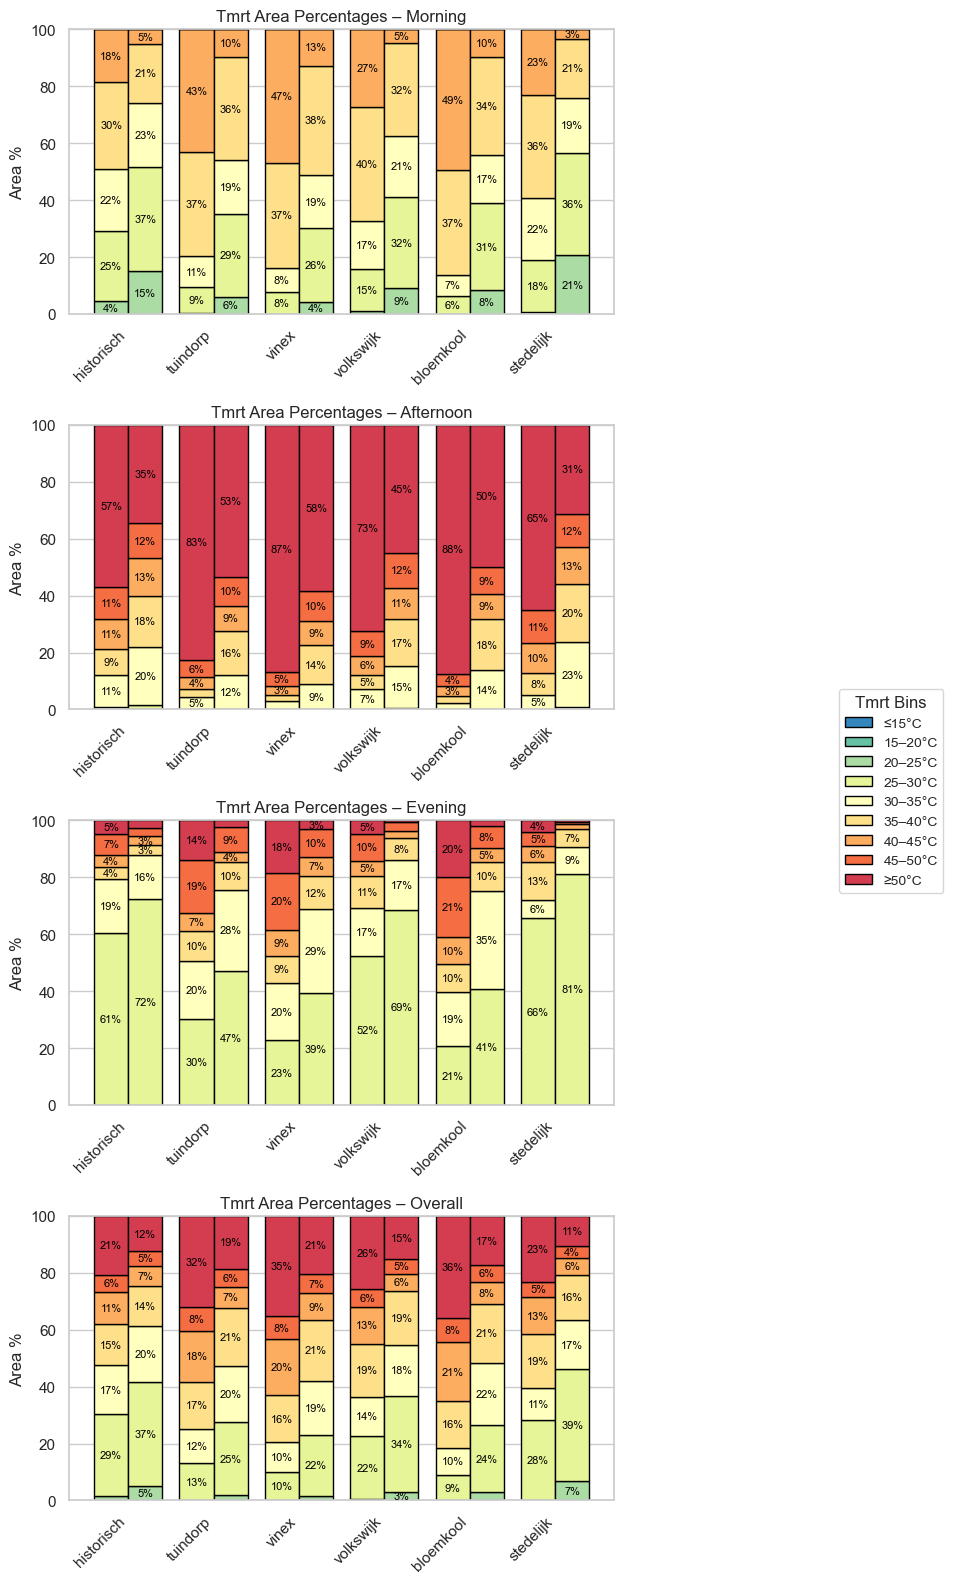

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
time_periods = ['morning', 'afternoon', 'evening', 'overall']
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']

# Extract percentage bin columns
percent_bin_cols = [col for col in df_all.columns if col.startswith('percent_bin_')]

# Create summary data list
summary_bins = []

for typ in typologies:
    for time in time_periods:
        for trees in [True, False]:  # True = without trees
            if time != 'overall':
                df_sub = df_all[
                    (df_all['typology'] == typ) &
                    (df_all['time'] == time) &
                    (df_all['avg_or_ext'] == day) &
                    (df_all['without_trees'] == trees)

                ]
            else:
                df_sub = df_all[
                    (df_all['typology'] == typ) &
                    (df_all['time'].isin(['morning', 'afternoon', 'evening'])) &
                    (df_all['avg_or_ext'] == day) &
                    (df_all['without_trees'] == trees)
                ]
            if df_sub.empty:
                continue

            percent_means = df_sub[percent_bin_cols].mean()

            for col in percent_bin_cols:
                bin_label = col.replace('percent_bin_', '')
                summary_bins.append({
                    'typology': typ,
                    'time': time,
                    'without_trees': trees,
                    'bin': bin_label,
                    'percent': percent_means[col]
                })

# Create DataFrame
df_bins_summary = pd.DataFrame(summary_bins)
df_bins_summary['Tree Cover'] = df_bins_summary['without_trees'].map({False: 'With Trees', True: 'Without Trees'})

# Sort typologies and bins
df_bins_summary['typology'] = pd.Categorical(df_bins_summary['typology'], categories=typologies, ordered=True)
bin_order = sorted(df_bins_summary['bin'].unique(), key=lambda x: float(x.split('_')[0]))
df_bins_summary['bin'] = pd.Categorical(df_bins_summary['bin'], categories=bin_order, ordered=True)


sns.set_theme(style='whitegrid')


bin_colors = sns.color_palette('Spectral', n_colors=len(bin_order))
bin_colors = bin_colors[::-1]

bin_label_map = {
    "0_-inf_15.0": "≤15°C",
    "1_15.0_20.0": "15–20°C",
    "2_20.0_25.0": "20–25°C",
    "3_25.0_30.0": "25–30°C",
    "4_30.0_35.0": "30–35°C",
    "5_35.0_40.0": "35–40°C",
    "6_40.0_45.0": "40–45°C",
    "7_45.0_50.0": "45–50°C",
    "8_50.0_inf": "≥50°C"
}
# Create figure and axes
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 16))
time_periods = ['morning', 'afternoon', 'evening', 'overall']
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
bar_width = 0.4
x = np.arange(len(typologies))

for idx, time in enumerate(time_periods):
    ax = axs[idx]
    plot_data = df_bins_summary[df_bins_summary['time'] == time]

    for i, tree_cover in enumerate(['Without Trees', 'With Trees']):
        bottoms = np.zeros(len(x))
        for j, bin_label in enumerate(bin_order):
            heights = plot_data[
                (plot_data['Tree Cover'] == tree_cover) &
                (plot_data['bin'] == bin_label)
            ].pivot(index='typology', columns='bin', values='percent').reindex(typologies)[bin_label].fillna(0).values

            bar_positions = x + (i - 0.5) * bar_width

            bars = ax.bar(
                bar_positions,
                heights,
                width=bar_width,
                bottom=bottoms,
                color=bin_colors[j],
                label=bin_label_map.get(bin_label, bin_label) if i == 0 else "",
                edgecolor='black'
            )

            # Add labels
            for rect, value in zip(bars, heights):
                if value > 3:
                    ax.text(
                        rect.get_x() + rect.get_width() / 2,
                        rect.get_y() + rect.get_height() / 2,
                        f"{value:.0f}%",
                        ha='center',
                        va='center',
                        fontsize=8,
                        color='black'
                    )

            bottoms += heights

    ax.set_ylabel("Area %")
    ax.set_title(f"Tmrt Area Percentages – {time.capitalize()}")
    ax.set_xticks(x)
    ax.set_xticklabels(typologies, rotation=45, ha='right')
    ax.set_ylim(0, 100)

# Final legend
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(),
    by_label.keys(),
    title="Tmrt Bins",
    bbox_to_anchor=(1.05, 0.5),  # Move legend outside the plot area
    loc='center left',  # Align legend vertically centered
    fontsize=10,
    title_fontsize=12
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.8, 1])

# plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig(f"plots/tmrt_grouped_stacked_combined_{day}.png")
plt.show()